# Анализ поведения пользователей в мобильном приложении "Ненужные вещи"

**Вводные данные** <br>
В приложении "Ненужные вещи" пользователи продают свои вещи, 
размещая их на доске объявлений. Целевым событием является - просмотр контактов (монетизация проекта построена вокруг доп.услуг продвижения объявлений). 
Перед командой проекта поставлена задача - увеличить конверсию в ЦД и вовлеченность пользователей в приложении. Для этого необходимо провести предварительный анализ поведения пользователей в приложении, чтобы "понять" - кто наши клиенты и выделить целевые аудитории. 

**Цель исследования:** <br>
Проанализировать связь целевого события(просмотра контактов) и других действий пользователей, определеить ключевые сценарии к ЦД. Проанализировать, на сколько эффективно работает рекомендательная система товаров. 
Оценить производительность приложения.

**Ход исследования**<br>
В нашем распоряжении имеются данные о пользователях, впервые совершивших действия 
в приложении после 7 октября 2019 года.

Наше исследование будет проходить в несколько ключевых этапов: 
 1. Обзор данных.
 2. Предобработка данных.
 3. Исследовательский анализ.
 4. Выдвижение и проверка гипотез
 5. Формирование общего вывода исследования

## Обзор данных

In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

# импортируем библиотеки
!pip install psycopg2-binary
import sys
import getopt
import pandas as pd
import  matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px  
import warnings
warnings.filterwarnings('ignore') 
#import datetime as dt
from datetime import datetime as dt
from datetime import timedelta
from scipy import stats as st
import math
import numpy as np 
!pip install tqdm
from tqdm import tqdm 
from time import sleep

!pip install plotly 
sns.set_theme(style="white", palette="Spectral_r") #ch:rot=-.25,hue=1,light=.75 #Set3 #rocked_r

Загрузим данные для анализа, изучим общую информацию о датасетах.<br>
Начнем с users, он для нас ключевой. Наметим предобработку.


### Загрузка и обзор mobile_dataset.csv

In [2]:
#загрузка датасета mobile_dataset.csv
link_users = '#'
try:
  users = pd.read_csv('/datasets/mobile_dataset.csv')
except:
  users = pd.read_csv(link_users)

users.head()

event.time   event.name  \
0  2019-10-07 00:00:00.431357  advert_open   
1  2019-10-07 00:00:01.236320    tips_show   
2  2019-10-07 00:00:02.245341    tips_show   
3  2019-10-07 00:00:07.039334    tips_show   
4  2019-10-07 00:00:56.319813  advert_open   

                                user.id  
0  020292ab-89bc-4156-9acf-68bc2783f894  
1  020292ab-89bc-4156-9acf-68bc2783f894  
2  cf7eda61-9349-469f-ac27-e5b6f5ec475c  
3  020292ab-89bc-4156-9acf-68bc2783f894  
4  cf7eda61-9349-469f-ac27-e5b6f5ec475c

In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


Пропусков нет - уже хорошо. Типы данных и названия колонок , конечно, придется менять.

In [4]:
users.duplicated().sum() 

0

Явных дубликатов нет. 

In [5]:
unique_users = users['user.id'].nunique()
print(f'Всего в датасете users {unique_users} уникальных пользователей')

Всего в датасете users 4293 уникальных пользователей


In [6]:
min_time, max_time = users['event.time'].min(), users['event.time'].max()
print(f'В датасете содержатся данные о действиях пользователей с {min_time} и по {max_time}')

В датасете содержатся данные о действиях пользователей с 2019-10-07 00:00:00.431357 и по 2019-11-03 23:58:12.532487


Сейчас гистограмму плотности распределения событий по времени не построить, так как не приведены типы -  сделаем это позже. 
За одно проанализируем важен ли нам весь этот период.

Теперь посмотрим на виды событий.

In [7]:
events_list = sorted(list(users['event.name'].unique()))
print('Всего у нас', users['event.name'].nunique(),'уникальных событий: ')
for event in events_list:
    print(event)

Всего у нас 16 уникальных событий: 
advert_open
contacts_call
contacts_show
favorites_add
map
photos_show
search_1
search_2
search_3
search_4
search_5
search_6
search_7
show_contacts
tips_click
tips_show


События однозначно содержат неявные дубликаты, разберемся с ними позже. 

Теперь тоже самое проделаем с sourses

### Загрузка и обзор mobile_sources.csv

In [8]:
#загрузка датасета mobile_sources.csv
link_sources = '#'
try:
  sources = pd.read_csv('/datasets/mobile_sources.csv')
except:
  sources = pd.read_csv(link_sources)

sources.head()

userId  source
0  020292ab-89bc-4156-9acf-68bc2783f894   other
1  cf7eda61-9349-469f-ac27-e5b6f5ec475c  yandex
2  8c356c42-3ba9-4cb6-80b8-3f868d0192c3  yandex
3  d9b06b47-0f36-419b-bbb0-3533e582a6cb   other
4  f32e1e2a-3027-4693-b793-b7b3ff274439  google

In [9]:
sources.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


Явных пропусков нет. Колонки в двух датасетах переименуем в едином стиле без заглавных букв.

In [10]:
users.duplicated().sum() 

0

Дубликатов тоже нет.

In [11]:
sources['userId'].nunique()

4293

Число уникальных пользователей идентично в обоих датасетах.

In [12]:
sources['source'].unique()

array(['other', 'yandex', 'google'], dtype=object)

В датасете всего 3 источника перехода, думаю они никак не влияют на "качество" пользователей. Попробуем проверить это в следующих главах.

## Предобработка данных

Все предварительные работы сделаны, теперь можно привести данные в порядок.

### Проверить и переименовать названия колонок

Все названия колонок приведем к стилю under_score для удобства и единообразия

In [13]:
users.columns = ['event_time','event_name','user_id']
users.head(2)

event_time   event_name  \
0  2019-10-07 00:00:00.431357  advert_open   
1  2019-10-07 00:00:01.236320    tips_show   

                                user_id  
0  020292ab-89bc-4156-9acf-68bc2783f894  
1  020292ab-89bc-4156-9acf-68bc2783f894

In [14]:
sources.columns = ['user_id','source']
sources.head(2)

user_id  source
0  020292ab-89bc-4156-9acf-68bc2783f894   other
1  cf7eda61-9349-469f-ac27-e5b6f5ec475c  yandex

### Исследовать пропущенные значения. Обработать пропуски

In [15]:
pd.DataFrame(round(users.isna().mean()*100,)).style.background_gradient('Spectral_r') #coolwarm

In [16]:
pd.DataFrame(round(sources.isna().mean()*100,)).style.background_gradient('Spectral_r') #coolwarm

Проверка показала, что пропусков и так нет. Отлично

### Привести типы данных к содержимому колонок

Из двух датасетов нас интересует только поле event_time в users.

In [17]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event_time  74197 non-null  object
 1   event_name  74197 non-null  object
 2   user_id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [18]:
#преобразуем в дату и время
users['event_time'] = pd.to_datetime(users['event_time'], format = '%Y-%m-%d %H:%M:%S')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


In [19]:
users.head(2)

event_time   event_name  \
0 2019-10-07 00:00:00.431357  advert_open   
1 2019-10-07 00:00:01.236320    tips_show   

                                user_id  
0  020292ab-89bc-4156-9acf-68bc2783f894  
1  020292ab-89bc-4156-9acf-68bc2783f894

Возможно, стоит округлить время до секунд? Создадим копию users и округлим поле event_time до секунд.

In [20]:
test_users = users.copy()
test_users['event_time'] = test_users['event_time'].astype('datetime64[s]')
test_users.head(2)

event_time   event_name                               user_id
0 2019-10-07 00:00:00  advert_open  020292ab-89bc-4156-9acf-68bc2783f894
1 2019-10-07 00:00:01    tips_show  020292ab-89bc-4156-9acf-68bc2783f894

Копия создана, проанализиируем дубли в следующей главе.

### Исследовать явные и неявные дубликаты. Удалить дубли 

Сначала проверим дубликаты в test_users.

In [21]:
test_users.duplicated().sum() 

1143

В users явных дубликатов не было, а тут появились. Посмотрим какие события чаще всего встречаются среди дублирующих.

In [22]:
filtr = test_users.duplicated()
(test_users[filtr].groupby('event_name', as_index = False)['user_id']
                  .agg('count')
                  .sort_values(by = 'user_id', ascending = False))

event_name  user_id
5    photos_show      660
2  contacts_show      153
9      tips_show      148
4            map      132
0    advert_open       18
6       search_1       18
1  contacts_call        7
3  favorites_add        3
8     tips_click        3
7       search_3        1

Получается, что за микросекунды пользователи успевают просмотреть фотографию, а еще и контакты! <br>
У нас нет никакой инфомрации о том, на сколько удобно и быстро разположена кнопка просмотра контакта (может контакты появляются при наведении мышки, или контаких можно посмотреть из краткой карточки объявления). <br>
Поэтому пока оставим все как есть c микросекундами, при необходимости вернемся к этому вопросу, когда будем изучать сессии пользователей. 

Вернемся к проверке users на дубли.

In [23]:
users.duplicated().sum() 

0

Поищем неявные дубликаты, начнем с event_time.

In [24]:
users['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7', 'show_contacts'], dtype=object)

Значения contacts_show и show_contacts по смыслу являются дублирующими.
Скорей всего конакты смотрятся в разных местах приложения (например на карте или в карточке объявления), но для нас это не важно - выполним замену события, которое встречается реже всего. 

In [25]:
users.groupby('event_name', as_index = False)['user_id'].agg('count').sort_values(by = 'user_id')

event_name  user_id
13  show_contacts       79
12       search_7      222
7        search_2      324
11       search_6      460
8        search_3      522
1   contacts_call      541
9        search_4      701
14     tips_click      814
10       search_5     1049
3   favorites_add     1417
6        search_1     3506
4             map     3881
2   contacts_show     4450
0     advert_open     6164
5     photos_show    10012
15      tips_show    40055

In [26]:
#замена show_contacts на contacts_show
users = users.replace(to_replace="show_contacts",value="contacts_show")
users.groupby('event_name', as_index = False)['user_id'].agg('count').sort_values(by = 'user_id')

event_name  user_id
12       search_7      222
7        search_2      324
11       search_6      460
8        search_3      522
1   contacts_call      541
9        search_4      701
13     tips_click      814
10       search_5     1049
3   favorites_add     1417
6        search_1     3506
4             map     3881
2   contacts_show     4529
0     advert_open     6164
5     photos_show    10012
14      tips_show    40055

Проверим не появились ли дубли, если так - то удалим. 

users.duplicated().sum() 

In [27]:
users = users.drop_duplicates()
users.duplicated().sum() 

0

С этим разобрались. Что касается действий search 1-7, не будем их объединять. Возможно, исследование покажет что-нибудь интересное.

Теперь посмотрим на sources.

In [28]:
users.duplicated().sum() 

0

Дубликатов нет, проверим нет ли в датасетах расхождений по user_id. 

In [29]:
list1 = sorted(list(sources['user_id'].unique()))
list2 = sorted(list(users['user_id'].unique()))

list1 ==list2

True

Список пользователей одинаков в обоих датасетах, значит данные полны и корректны. 

### Добавить новые данные, необходимые для исследования

Добавим отдельную колонку с датой событий, она может пригодится для дальнейшего анализа.

In [30]:
users['event_date'] = users['event_time'].dt.date
users['event_date'] = pd.to_datetime(users['event_date'], format = '%Y.%m.%d')
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74197 entries, 0 to 74196
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
 3   event_date  74197 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 2.8+ MB


In [31]:
users.head()

event_time   event_name  \
0 2019-10-07 00:00:00.431357  advert_open   
1 2019-10-07 00:00:01.236320    tips_show   
2 2019-10-07 00:00:02.245341    tips_show   
3 2019-10-07 00:00:07.039334    tips_show   
4 2019-10-07 00:00:56.319813  advert_open   

                                user_id event_date  
0  020292ab-89bc-4156-9acf-68bc2783f894 2019-10-07  
1  020292ab-89bc-4156-9acf-68bc2783f894 2019-10-07  
2  cf7eda61-9349-469f-ac27-e5b6f5ec475c 2019-10-07  
3  020292ab-89bc-4156-9acf-68bc2783f894 2019-10-07  
4  cf7eda61-9349-469f-ac27-e5b6f5ec475c 2019-10-07

Все подготовительные работы проведены - наши данные готовы к анализу.

## Исследовательский анализ

### Анализ действий пользователей в приложении

#### Проанализировать количество событий по дням (DAU). Построить график

Посмотрим на сколько активно пользователи пользуются приложением - выведем информацию о том, сколько уникальных пользователй совершало действия по дням. 

In [32]:
dau_1 = users.groupby('event_date', as_index=False)['event_time'].agg('count')
dau_1.event_time.median()

2725.0

In [33]:
dau = users.groupby('event_date', as_index=False)['user_id'].agg('nunique')
dau

event_date  user_id
0  2019-10-07      204
1  2019-10-08      204
2  2019-10-09      227
3  2019-10-10      233
4  2019-10-11      206
5  2019-10-12      178
6  2019-10-13      226
7  2019-10-14      298
8  2019-10-15      303
9  2019-10-16      278
10 2019-10-17      307
11 2019-10-18      308
12 2019-10-19      271
13 2019-10-20      274
14 2019-10-21      326
15 2019-10-22      310
16 2019-10-23      352
17 2019-10-24      319
18 2019-10-25      305
19 2019-10-26      287
20 2019-10-27      299
21 2019-10-28      348
22 2019-10-29      312
23 2019-10-30      313
24 2019-10-31      325
25 2019-11-01      279
26 2019-11-02      240
27 2019-11-03      285

In [34]:
#создаем список дней для оси X
dau_list = list(dau['event_date'].astype(str))
dau_list[:5]

['2019-10-07', '2019-10-08', '2019-10-09', '2019-10-10', '2019-10-11']

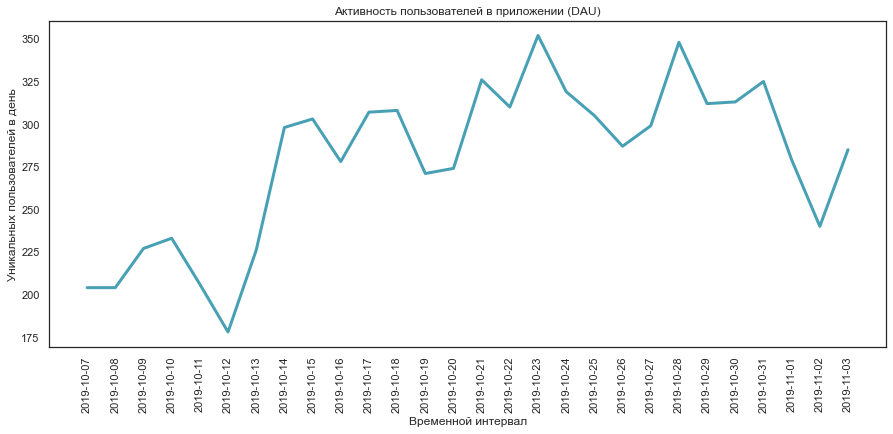

In [35]:
#Строим график
fig = plt.subplots(figsize=(15, 6))
sns.lineplot(x="event_date", y="user_id", linewidth=3, data=dau)
#plt.grid()
plt.title("Активность пользователей в приложении (DAU)");
plt.xlabel('Временной интервал') 
plt.ylabel('Уникальных пользователей в день') 
plt.xticks(dau_list);
plt.xticks(rotation=90)
plt.show();

График получился волнообразный, но некоторые выводы по нему все же можно сделать:<br>
 - пользователи активно пользуются приложением, их вовлеченность растет со временем
 - активноть пользователей циклична, имеет взлеты и падения, причем 1 цикл = 1 неделя.
 - кажется, что в период до 2019-10-12 пользователи только начинали пользоваться приложением, возможно этот отрезок можно не учивать в анализе.
 - самый низкий показатель активности  - 2019-10-12 (суббота), самый высокий - 2019-10-23 (среда).
    
Любопытно, в какой день недели пользователи реже всего пользуются приложением. Проверим.

In [36]:
dau['week_day'] = pd.to_datetime(dau['event_date'], format = '%Y.%m.%d').dt.weekday
dau

event_date  user_id  week_day
0  2019-10-07      204         0
1  2019-10-08      204         1
2  2019-10-09      227         2
3  2019-10-10      233         3
4  2019-10-11      206         4
5  2019-10-12      178         5
6  2019-10-13      226         6
7  2019-10-14      298         0
8  2019-10-15      303         1
9  2019-10-16      278         2
10 2019-10-17      307         3
11 2019-10-18      308         4
12 2019-10-19      271         5
13 2019-10-20      274         6
14 2019-10-21      326         0
15 2019-10-22      310         1
16 2019-10-23      352         2
17 2019-10-24      319         3
18 2019-10-25      305         4
19 2019-10-26      287         5
20 2019-10-27      299         6
21 2019-10-28      348         0
22 2019-10-29      312         1
23 2019-10-30      313         2
24 2019-10-31      325         3
25 2019-11-01      279         4
26 2019-11-02      240         5
27 2019-11-03      285         6

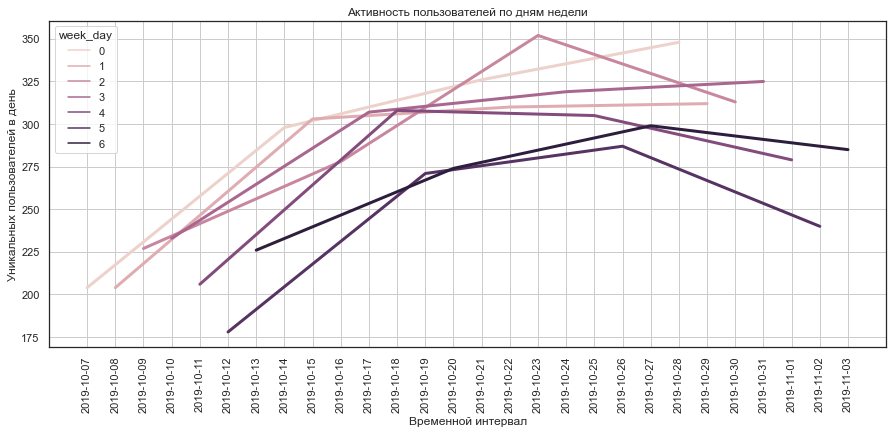

In [37]:
#строим график по дням недели
fig = plt.subplots(figsize=(15, 6))
sns.lineplot(x="event_date", y="user_id", hue='week_day', linewidth=3, data=dau)
plt.grid()
plt.title("Активность пользователей по дням недели");
plt.xlabel('Временной интервал') 
plt.ylabel('Уникальных пользователей в день') 
plt.xticks(dau_list);
plt.xticks(rotation=90)
plt.show();

Мы построили тот же самый график по дням недели. Однозначно можно сказать, что день "затишья" - это суббота, именно в субботу самая минимальная активность у пользователей, зато начиная с воскресесья активность начинает расти, достигает свеого пика до середны недели и снова падает к субботе. Любопытно. 
Что касается прироста, то он по дням распределен равномерно, графики повторяют одну траекторию во все дни недели. 

In [38]:
dau

event_date  user_id  week_day
0  2019-10-07      204         0
1  2019-10-08      204         1
2  2019-10-09      227         2
3  2019-10-10      233         3
4  2019-10-11      206         4
5  2019-10-12      178         5
6  2019-10-13      226         6
7  2019-10-14      298         0
8  2019-10-15      303         1
9  2019-10-16      278         2
10 2019-10-17      307         3
11 2019-10-18      308         4
12 2019-10-19      271         5
13 2019-10-20      274         6
14 2019-10-21      326         0
15 2019-10-22      310         1
16 2019-10-23      352         2
17 2019-10-24      319         3
18 2019-10-25      305         4
19 2019-10-26      287         5
20 2019-10-27      299         6
21 2019-10-28      348         0
22 2019-10-29      312         1
23 2019-10-30      313         2
24 2019-10-31      325         3
25 2019-11-01      279         4
26 2019-11-02      240         5
27 2019-11-03      285         6

#### Определить временной интервал, в который больше всего пользователей проявляют активность в приложении

Для этого добавим новый столбец и сгруппируем данные действий пользователей по часам. Таким образом, мы увидим когда в приложении "шурстит" больше всего пользователей.

In [39]:
users['event_hour'] = users['event_time'].dt.hour
users.sample(5)

event_time   event_name  \
62573 2019-10-30 15:43:06.611180    tips_show   
15087 2019-10-13 20:40:24.473014    tips_show   
3833  2019-10-08 15:03:01.312134    tips_show   
37877 2019-10-22 12:58:05.841942  advert_open   
8115  2019-10-10 14:47:16.109679          map   

                                    user_id event_date  event_hour  
62573  a78a8bd5-85b0-47f8-9975-fe378943f5dd 2019-10-30          15  
15087  1904a95e-b08d-489f-9f51-334457e4d0d6 2019-10-13          20  
3833   f31102e5-7cf9-47b9-bc87-1f7011c4e2b0 2019-10-08          15  
37877  076f2de3-268b-4cf1-ade7-73d09752e3b3 2019-10-22          12  
8115   e98d0360-a876-485c-9a5b-a2c8d655fb61 2019-10-10          14

In [40]:
hau = users.groupby('event_hour', as_index = False).agg({'user_id':'nunique'})
hau

event_hour  user_id
0            0      243
1            1      126
2            2       65
3            3       34
4            4       29
5            5       25
6            6       53
7            7      122
8            8      275
9            9      473
10          10      561
11          11      622
12          12      699
13          13      700
14          14      734
15          15      729
16          16      737
17          17      596
18          18      594
19          19      652
20          20      685
21          21      692
22          22      568
23          23      421

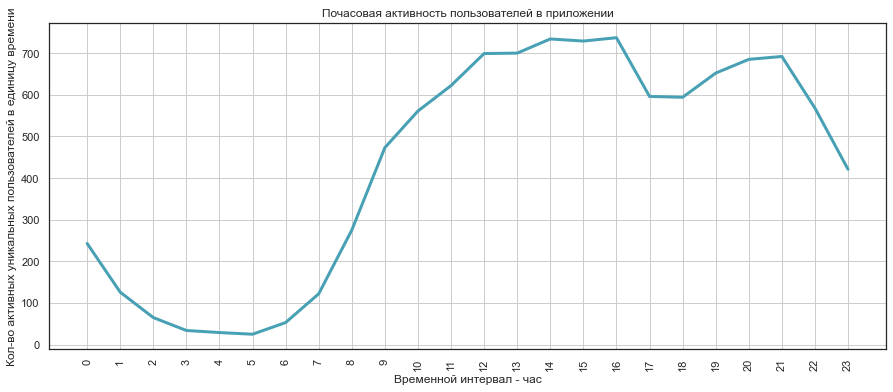

In [41]:
#Строим график
fig = plt.subplots(figsize=(15, 6))
sns.lineplot(x="event_hour", y="user_id", linewidth=3, data=hau)
plt.grid()
plt.title("Почасовая активность пользователей в приложении");
plt.xlabel('Временной интервал - час') 
plt.ylabel('Кол-во активных уникальных пользователей в единицу времени') 
plt.xticks([i for i in range(0,24)]);
plt.xticks(rotation=90)
plt.show();

Получился красивый и достаточно логичный график. Он говорит нам о следующем:
- рост активности начинается с 5 утра, с 7 (видимо - время подъема среднестатистического рабочего человека) он резко взлетает вверх. 
- после 9 утра рост продолжается, но уже спокойнее, так как отвлекают рабочие дела. 
- своего пика график достигает в 14 и 16 часов. после идет резкий спад. активность возобновляется после 18 вечера 
- после 21 активность резко падет вниз. все готовятся ко сну.
<br>Можно заметить 2 интересных периода - с 12 до 13 и с 17 до 18. В этих периодах график выравнивается. Можно прежположить, что именно в это время пользователи стремительно покидают свое рабочее место на обед и домой. Или же начинают активнее решать рабочие задачи, дабв по максимуму успеть до перерыва.

#### Определить временной интервал, когда пользователи чаще всего совершают целевое действие (время / день недели)

Делаем все то же самое, только с применением фильтра на целевых пользователей.

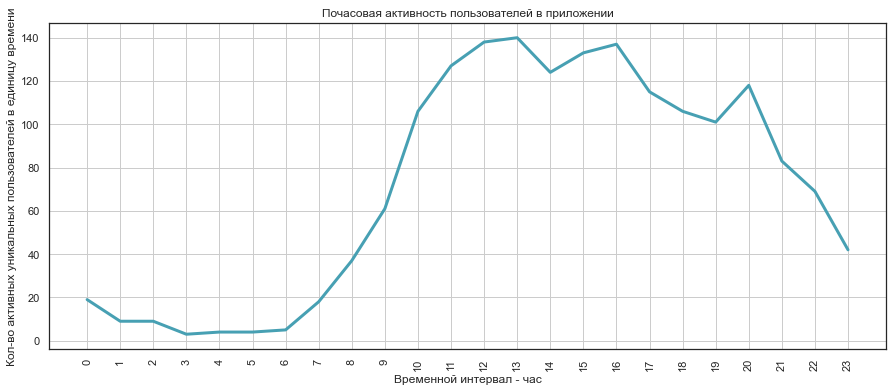

In [42]:
target_hau = users.query('event_name=="contacts_show"').groupby('event_hour', as_index = False).agg({'user_id':'nunique'})

#Строим график
fig = plt.subplots(figsize=(15, 6))
sns.lineplot(x="event_hour", y="user_id", linewidth=3, data=target_hau)
plt.grid()
plt.title("Почасовая активность пользователей в приложении");
plt.xlabel('Временной интервал - час') 
plt.ylabel('Кол-во активных уникальных пользователей в единицу времени') 
plt.xticks([i for i in range(0,24)]);
plt.xticks(rotation=90)
plt.show();

В общем поведении график повторяет предыдущий. 
На нем можно выделить 3 пика активности по совершению целевого действия - в 13 часов (самое популярное время),
в 16 часов и в 20 вечера (те, кто предпочитает решать личные вопросы дома и после ужина). 

#### Выделить самые распространенные события пользователей в приложении

In [43]:
dataevents = users.groupby('event_name', as_index=False)['user_id'].agg({'user_id':'nunique'}).sort_values(by='user_id', ascending = False)
dataevents['users_%'] = round(dataevents['user_id'] / unique_users *100,1).astype(str) + ' %'
dataevents

event_name  user_id users_%
14      tips_show     2801  65.2 %
4             map     1456  33.9 %
5     photos_show     1095  25.5 %
2   contacts_show      981  22.9 %
6        search_1      787  18.3 %
0     advert_open      751  17.5 %
10       search_5      663  15.4 %
9        search_4      474  11.0 %
3   favorites_add      351   8.2 %
11       search_6      330   7.7 %
13     tips_click      322   7.5 %
7        search_2      242   5.6 %
1   contacts_call      213   5.0 %
8        search_3      208   4.8 %
12       search_7      157   3.7 %

In [44]:
#столбчатая диаграмма популярности разных типов событий среди пользователей приложения 

fig = px.bar(dataevents, 
             x='event_name', 
             y='user_id', 
             text = 'users_%', 
             color = 'event_name',
             labels = {'event_name':'Тип события', 
                       'user_id':'Уникальных пользователей',
                      'event_time':'Количество таких действий по всем пользователям',
                      'users_%':'% пользователей, которые хоть раз совершали событие'},
             title='Популярность разных типов событий среди пользователей приложения') 
fig.update_xaxes(title_text = ' Типы событий, совершаемые в приложении ')
fig.update_yaxes(title_text = 'Количество уникальных пользователей')
fig.show();

Сервис показала рекомендаций работает более, чем хорошо (возможно слишком хорошо), 
ведь 65.2 % всех пользователей видят рекомендации. 
Следующее по популярности событие - открытие карты объявлений - почти 34 % пользователей совершнают его.
25.5 % - смотрят фотографии. 22.9 % пользователей просматривают контакты (ключевое действие). 
Самое не популярное событие - какая-то разновидность поиска (search_7) - возможно, настройка не самого популярного фильтра.

Посмотрим, как изменится график, если обьединить все события поиска в одну группу. 

In [45]:
dataevents_test = dataevents.replace(to_replace=['search_1','search_2','search_3','search_4','search_5','search_6','search_7'],value="search")
dataevents_test = dataevents_test.groupby('event_name', as_index = False)['user_id'].agg('sum').sort_values(by = 'user_id', ascending = False)
dataevents_test['users_%'] = round(dataevents_test['user_id'] / unique_users *100,1).astype(str) + ' %'
dataevents_test

event_name  user_id users_%
6         search     2861  66.6 %
8      tips_show     2801  65.2 %
4            map     1456  33.9 %
5    photos_show     1095  25.5 %
2  contacts_show      981  22.9 %
0    advert_open      751  17.5 %
3  favorites_add      351   8.2 %
7     tips_click      322   7.5 %
1  contacts_call      213   5.0 %

In [46]:
#столбчатая диаграмма популярности разных типов событий среди пользователей приложения 

fig = px.bar(dataevents_test, 
             x='event_name', 
             y='user_id', 
             text = 'users_%', 
             color = 'event_name',
             labels = {'event_name':'Тип события', 
                       'user_id':'Уникальных пользователей',
                      'users_%':'% пользователей, которые хоть раз совершали событие'},
             title='Популярность разных типов событий среди пользователей приложения') 
fig.update_xaxes(title_text = ' Типы событий, совершаемые в приложении ')
fig.update_yaxes(title_text = 'Количество уникальных пользователей')
fig.show();

Картина правдоподобная, 66.6 % пользователей пользуются поиском в приложении со всеми его настройками, это самое популярное действие. 
Похоже показ рекомендаций зашит в результаты поиска или сам фильтр, иначе первые два события не были бы такими близкими по значению. 
Теперь самое непопулярное событие - позвонить по контакту (5%), этот сервис совсем не пользуется спросом на фоне остальных событий.

#### Какие события влияют на конверсию в целевое действие ?

Создадим таблицу, в которой покажем сколько уникальных пользователей совершали каждое действие в приложении

In [47]:
convr_table = users.groupby('event_name', as_index=False)['user_id'].agg('nunique')
convr_table.columns = ['event_name', 'users']
convr_table

event_name  users
0     advert_open    751
1   contacts_call    213
2   contacts_show    981
3   favorites_add    351
4             map   1456
5     photos_show   1095
6        search_1    787
7        search_2    242
8        search_3    208
9        search_4    474
10       search_5    663
11       search_6    330
12       search_7    157
13     tips_click    322
14      tips_show   2801

Создадим функцию, которая будет принимать событие в приложении в качестве аргумента и возвращать количество уникальных пользователей, которые ххотя бы раз совершили переданное событие и хотя бы раз сделали целевое действие.

In [48]:
#список пользователей, которые совершили целевое действие
filtr = sorted(list(users.query('event_name=="contacts_show"')['user_id'].unique()))

def found_convers (event):
    event_filtr = list(users.query('event_name==@event')['user_id'].unique())
    count_convrs = len(list(set(filtr) & set(event_filtr)))
    return count_convrs

#проверка
found_convers('search_6')

52

Теперь добавим в convr_table столбец с конверсией пользователей и посчитаем результат в процентах

In [49]:
convr_table['convr_users'] = convr_table['event_name'].apply(found_convers)
convr_table

event_name  users  convr_users
0     advert_open    751          138
1   contacts_call    213          213
2   contacts_show    981          981
3   favorites_add    351          136
4             map   1456          289
5     photos_show   1095          339
6        search_1    787          237
7        search_2    242           55
8        search_3    208           38
9        search_4    474           88
10       search_5    663          114
11       search_6    330           52
12       search_7    157           25
13     tips_click    322          100
14      tips_show   2801          516

In [50]:
convr_table['convs_in_show'] = round(convr_table['convr_users'] / convr_table['users'] *100,2)
convr_table = convr_table.query('event_name!="contacts_show"').sort_values(by = 'convs_in_show', ascending = False).reset_index(drop=True)
convr_table

event_name  users  convr_users  convs_in_show
0   contacts_call    213          213         100.00
1   favorites_add    351          136          38.75
2      tips_click    322          100          31.06
3     photos_show   1095          339          30.96
4        search_1    787          237          30.11
5        search_2    242           55          22.73
6             map   1456          289          19.85
7        search_4    474           88          18.57
8       tips_show   2801          516          18.42
9     advert_open    751          138          18.38
10       search_3    208           38          18.27
11       search_5    663          114          17.19
12       search_7    157           25          15.92
13       search_6    330           52          15.76

In [51]:
#Как события влияют на конверсию в целевое действие в приложении
fig = px.bar(convr_table, 
             x='event_name', 
             y='convs_in_show', 
             text = 'convs_in_show', 
             color = 'event_name',
             labels = {'event_name':'Тип события', 
                      'convs_in_show':'% пользователей, которые хоть раз совершали событие и ЦД'},
             title='Как события влияют на конверсию в целевое действие') 
fig.update_xaxes(title_text = 'События,совершаемые пользователями в приложении')
fig.update_yaxes(title_text = '% пользователей, сконвертировавшихся в ЦД')
fig.show();

Мы сделали достаточно грубый анализ без учета последовательностей действий и временных сессий. На графике мы просто показываем общую статистику, какова вероятность того, что если пользователь совершает действие в приложении, то оно рано или поздно приведет его к ЦД. 
Мы убрали из списка событий ЦД, но с таким же успехом можно было бы исключить "contacts_call". 
Конверсия по нему 100%, это может значить лишь то, что эти сервисы работают в связке - нельзя позвонить, не увидев при этом контакты. favorites_add - вот наш победитель, если пользователь хотя бы раз добавлял товары в избранное, что 38.75% у него будет целевое действие. посмореть рекомендацию, фото или открыть поиск - идут следом по популярности с небольшими разрывами по конверсии. Хуже всех конверсия проявляется у событий поиска seach 3,5,6,7. Возможно, эти фильтры вовсе не нужны пользователям. 


#### Проанализировать, какие действия чаще совершают те пользователи, которые просматривают контакты

Список таких пользователей у нас уже есть, сгруппируем данные по event_name и выведем количество событий.

In [52]:
len(filtr)

981

In [53]:
target_users = users.query('(user_id in @filtr) and (event_name!="contacts_show")').groupby('event_name', as_index = False).agg({'user_id':'nunique'}).sort_values(by = 'user_id', ascending = False).reset_index(drop=True)
target_users['users_%'] = round(target_users['user_id'] / len(filtr) * 100,2)
target_users

event_name  user_id  users_%
0       tips_show      516    52.60
1     photos_show      339    34.56
2             map      289    29.46
3        search_1      237    24.16
4   contacts_call      213    21.71
5     advert_open      138    14.07
6   favorites_add      136    13.86
7        search_5      114    11.62
8      tips_click      100    10.19
9        search_4       88     8.97
10       search_2       55     5.61
11       search_6       52     5.30
12       search_3       38     3.87
13       search_7       25     2.55

In [54]:
#столбчатая диаграмма популярности разных типов событий среди целевых пользователей (ЦД)

fig = px.bar(target_users, 
             x='event_name', 
             y='user_id', 
             text = 'users_%', 
             color = 'event_name',
             labels = {'event_name':'Тип события', 
                       'user_id':'Уникальных пользователей',
                      'users_%':'% пользователей, которые хоть раз совершали событие'},
             title='Популярность разных типов событий среди пользователей, совершивших ЦД') 
fig.update_xaxes(title_text = ' Типы событий, совершаемые в приложении ')
fig.update_yaxes(title_text = 'Количество уникальных целевых пользователей')
fig.show();

Результат очень похож на диаграмму, которую мы получали ранее для всех пользователей - показ рекомендации самое популярное действие. На это событие , мне кажется в данном разрезе можно не сильно обращаться внимание, сервис работает для всех пользователей одинаково. 
Зато следующим по популярности у целевых пользователей идет просмотр фотографий (34.56 %) и уже только потом объявлениям на карте (почти 30%). стоит отметить , что почти 22 % из целевой аудитории пользуется сервисом звонка через приложение. 
Самыми не популярными остаются группа поисковых действий search_2,3,4,6,7.
Вообще нужно отметить, что на данном этапе исследования search_1 и search_5 - самые востребованные в поисковых действиях.

### Анализ сессий пользователей

Дальнейший анализ будем проводить в рамках сессий пользователей. Попробуем определить временной интервал между действиями, 
на основе которого можно разделить все сессии в приложении. Но для начала округлим event_time до секунд.

In [55]:
users.event_time = users.event_time.astype('datetime64[s]')
users.head(1)

event_time   event_name                               user_id event_date  \
0 2019-10-07  advert_open  020292ab-89bc-4156-9acf-68bc2783f894 2019-10-07   

   event_hour  
0           0

Првоерим и удалим дубликаты.

In [56]:
users.duplicated().sum() 

1143

In [57]:
users = users.drop_duplicates()

In [58]:
users.duplicated().sum() 

0

In [59]:
#считаем интервал между действиями по каждому пользователю
users = users.sort_values(by = ['user_id','event_time'])
users['delta'] = users.groupby(['user_id'])['event_time'].apply(lambda x: x.diff())
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73054 entries, 805 to 72689
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype          
---  ------      --------------  -----          
 0   event_time  73054 non-null  datetime64[ns] 
 1   event_name  73054 non-null  object         
 2   user_id     73054 non-null  object         
 3   event_date  73054 non-null  datetime64[ns] 
 4   event_hour  73054 non-null  int64          
 5   delta       68761 non-null  timedelta64[ns]
dtypes: datetime64[ns](2), int64(1), object(2), timedelta64[ns](1)
memory usage: 3.9+ MB


Дла анализа нам потребуются конкретные единицы измерения, добавим столбец, который будет выражать дельту в минутах.

In [60]:
users['delta_min'] = users['delta'].astype('timedelta64[m]', errors = 'ignore').astype('int64', errors = 'ignore').fillna(0)
users.sample(5)

event_time   event_name                               user_id  \
47377 2019-10-25 14:41:10    tips_show  d13ac597-16ce-42a9-949d-edc5e291f26e   
27560 2019-10-18 10:44:37     search_5  a5c06f61-c880-46b1-ab85-dca1252cc922   
64712 2019-10-31 11:37:31  advert_open  a9789b1d-d9ff-4b1b-9925-ddbc8abfe726   
6651  2019-10-09 19:07:44    tips_show  2770de56-fd90-4c64-8a16-825edf103127   
21340 2019-10-15 22:06:32    tips_show  13250b98-e1d1-45dd-a055-c84b7b19720b   

      event_date  event_hour           delta  delta_min  
47377 2019-10-25          14 0 days 00:00:48        0.0  
27560 2019-10-18          10 0 days 00:00:04        0.0  
64712 2019-10-31          11 5 days 22:59:17     8579.0  
6651  2019-10-09          19 0 days 00:00:04        0.0  
21340 2019-10-15          22 0 days 00:11:18       11.0

Посмотрим, как распределяются интвервалы между действиями по всем пользователям.

In [61]:
total = users.delta_min.describe()
print(total)
vybros = (total[6] + (total[6] - total[4])*1.5)
print(f'Выбросы начинаются со значения = {vybros}')

count    73054.000000
mean       222.570660
std       1500.273267
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max      38269.000000
Name: delta_min, dtype: float64
Выбросы начинаются со значения = 5.0


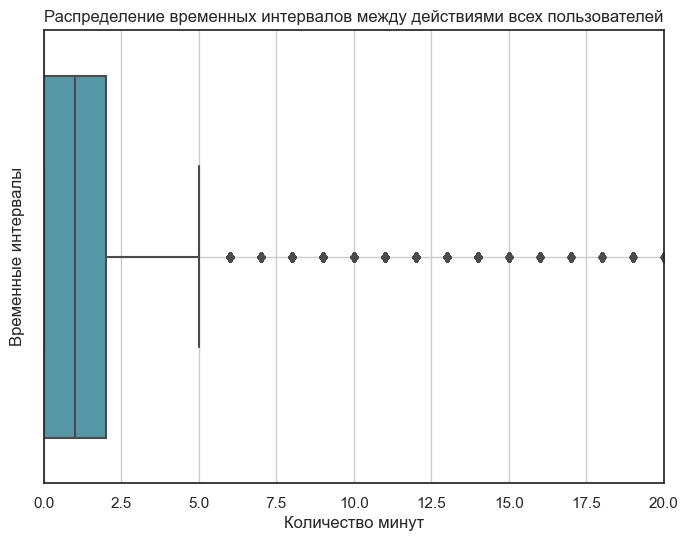

In [62]:
#ящик с усами
plt.figure(figsize=(8, 6), dpi=100)
palette = sns.color_palette("Spectral_r")
sns.boxplot(data=users, x="delta_min",  palette=palette)
plt.grid(True)
plt.title('Распределение временных интервалов между действиями всех пользователей')
plt.xlabel('Количество минут') # подписи осей средствами matplotlib
plt.ylabel('Временные интервалы') # подписи осей средствами matplotlib
plt.xlim(0,20)
plt.show()

Ящик с усами говорит нам о том, что сессии, продолжительностью более 5 минут, уже являются выбросами на фоне общего распределения интервалов. Посчитаем сколько данных находится в выбросах

In [63]:
users.query('delta_min>@vybros')['user_id'].count() / total[0] *100

14.717879924439456

Выбросы составляют почти 15 % данных. Посчитаем на всякий случай перцентили. 

In [64]:
np.percentile(users.delta_min , [85,86,87,88,89,90])

array([ 5.,  6.,  7.,  9., 11., 14.])

Мы ничего не знаем о качестве анализируемого приложения, но все же кажется, что сессия в 5 минут слишком коротка.
Например, в авито в 2021 году средняя сессия пользователя длилась 11 минут (https://www.avito.ru/b2b/most-popular-classified/).
Для уверенности, возьмем значение сессии = 15 минут.

#### Распределить все действия пользователей по сессиям активности в приложении

Теперь, распределим действия наших пользователей по сессиям. 

In [65]:
users.head()

event_time event_name                               user_id  \
805 2019-10-07 13:39:45  tips_show  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   
806 2019-10-07 13:40:31  tips_show  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   
809 2019-10-07 13:41:05  tips_show  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   
820 2019-10-07 13:43:20  tips_show  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   
830 2019-10-07 13:45:30  tips_show  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   

    event_date  event_hour           delta  delta_min  
805 2019-10-07          13             NaT        0.0  
806 2019-10-07          13 0 days 00:00:46        0.0  
809 2019-10-07          13 0 days 00:00:34        0.0  
820 2019-10-07          13 0 days 00:02:15        2.0  
830 2019-10-07          13 0 days 00:02:10        2.0

In [66]:
td = pd.Timedelta(15, "m")
td

Timedelta('0 days 00:15:00')

In [67]:
#convert to datetimes
users['event_time'] = pd.to_datetime(users['event_time'])
#разрезаем действия пользователя в сессии с интервалом в 15 минут
g = (users.groupby('user_id')['event_time'].diff() > pd.Timedelta('0 days 00:15:00')).cumsum()
#задаем номер сессии
users['session_id'] = users.groupby(['user_id', g], sort=False).ngroup() + 1
users.query('user_id=="045cc772-3e56-4e9c-965d-fc7353cd3894"').head(10)

event_time event_name                               user_id  \
16312 2019-10-14 10:21:20   search_4  045cc772-3e56-4e9c-965d-fc7353cd3894   
16313 2019-10-14 10:21:26   search_5  045cc772-3e56-4e9c-965d-fc7353cd3894   
16314 2019-10-14 10:21:37        map  045cc772-3e56-4e9c-965d-fc7353cd3894   
16320 2019-10-14 10:23:25  tips_show  045cc772-3e56-4e9c-965d-fc7353cd3894   
16324 2019-10-14 10:24:15  tips_show  045cc772-3e56-4e9c-965d-fc7353cd3894   
16325 2019-10-14 10:24:42  tips_show  045cc772-3e56-4e9c-965d-fc7353cd3894   
16328 2019-10-14 10:25:20  tips_show  045cc772-3e56-4e9c-965d-fc7353cd3894   
16329 2019-10-14 10:27:06  tips_show  045cc772-3e56-4e9c-965d-fc7353cd3894   
16330 2019-10-14 10:27:36  tips_show  045cc772-3e56-4e9c-965d-fc7353cd3894   
16332 2019-10-14 10:28:05        map  045cc772-3e56-4e9c-965d-fc7353cd3894   

      event_date  event_hour           delta  delta_min  session_id  
16312 2019-10-14          10             NaT        0.0         159  
16313 2019-10-14          10 0 days 00:00:06        0.0         159  
16314 2019-10-14          10 0 days 00:00:11        0.0         159  
16320 2019-10-14          10 0 days 00:01:48        1.0         159  
16324 2019-10-14          10 0 days 00:00:50        0.0         159  
16325 2019-10-14          10 0 days 00:00:27        0.0         159  
16328 2019-10-14          10 0 days 00:00:38        0.0         159  
16329 2019-10-14          10 0 days 00:01:46        1.0         159  
16330 2019-10-14          10 0 days 00:00:30        0.0         159  
16332 2019-10-14          10 0 days 00:00:29        0.0         159

#### Проанализировать неявные дубликаты действий  в сессиях каждого пользователя и удалить их.

Чтобы понять, как ведет себя пользователь и какие дубли можно смело исключить - посмотрим пару сессий пользователей.

In [68]:
#Общее кол-во сессий
users.session_id.nunique()

11537

In [69]:
users.query('session_id==10511').sort_values(by='event_time')

event_time     event_name  \
47151 2019-10-25 13:44:47       search_1   
47153 2019-10-25 13:44:56       search_1   
47157 2019-10-25 13:46:47  favorites_add   
47168 2019-10-25 13:50:02       search_1   
47170 2019-10-25 13:50:10       search_1   
47172 2019-10-25 13:50:30       search_1   
47175 2019-10-25 13:50:55       search_1   
47183 2019-10-25 13:51:58       search_1   
47185 2019-10-25 13:52:16  favorites_add   
47190 2019-10-25 13:53:11       search_1   
47192 2019-10-25 13:53:27       search_1   
47195 2019-10-25 13:53:45  favorites_add   
47197 2019-10-25 13:53:49  favorites_add   
47199 2019-10-25 13:54:25  favorites_add   
47204 2019-10-25 13:55:34  favorites_add   
47208 2019-10-25 13:55:50  favorites_add   
47211 2019-10-25 13:56:27  favorites_add   
47213 2019-10-25 13:57:30  favorites_add   
47216 2019-10-25 13:58:22  favorites_add   
47220 2019-10-25 13:59:08  favorites_add   
47224 2019-10-25 13:59:33  favorites_add   
47228 2019-10-25 14:00:03  favorites_add   
47235 2019-10-25 14:01:14  favorites_add   
47271 2019-10-25 14:15:06    advert_open   
47272 2019-10-25 14:15:15    advert_open   
47274 2019-10-25 14:15:20    photos_show   

                                    user_id event_date  event_hour  \
47151  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
47153  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
47157  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
47168  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
47170  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
47172  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
47175  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
47183  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
47185  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
47190  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
47192  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
47195  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
47197  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
47199  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
47204  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
47208  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
47211  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
47213  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
47216  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
47220  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
47224  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
47228  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          14   
47235  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          14   
47271  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          14   
47272  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          14   
47274  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          14   

                delta  delta_min  session_id  
47151             NaT        0.0       10511  
47153 0 days 00:00:09        0.0       10511  
47157 0 days 00:01:51        1.0       10511  
47168 0 days 00:03:15        3.0       10511  
47170 0 days 00:00:08        0.0       10511  
47172 0 days 00:00:20        0.0       10511  
47175 0 days 00:00:25        0.0       10511  
47183 0 days 00:01:03        1.0       10511  
47185 0 days 00:00:18        0.0       10511  
47190 0 days 00:00:55        0.0       10511  
47192 0 days 00:00:16        0.0       10511  
47195 0 days 00:00:18        0.0       10511  
47197 0 days 00:00:04        0.0       10511  
47199 0 days 00:00:36        0.0       10511  
47204 0 days 00:01:09        1.0       10511  
47208 0 days 00:00:16        0.0       10511  
47211 0 days 00:00:37        0.0       10511  
47213 0 days 00:01:03        1.0       10511  
47216 0 days 00:00:52        0.0       105

In [70]:
dubli = users[['event_time','event_name','session_id']].duplicated()
dubli.sum()

0

In [71]:
users[dubli].user_id.nunique()

0

In [72]:
users = users.sort_values('event_time').drop_duplicates(['event_time','event_name','session_id'], keep='first')


In [73]:
users[['event_time','event_name','session_id']].duplicated().sum()

0

Очевидные дубли удалили. Перед тем как двинутся дальше, сделаем копию датасета, на ее основе потом будем определять среднее время сессии пользователей. 

In [74]:
#создаем датасет для анализа средней продолжительности времени сессии
full_users = users.copy().reset_index(drop=True)
full_users.head()

event_time   event_name                               user_id  \
0 2019-10-07 00:00:00  advert_open  020292ab-89bc-4156-9acf-68bc2783f894   
1 2019-10-07 00:00:01    tips_show  020292ab-89bc-4156-9acf-68bc2783f894   
2 2019-10-07 00:00:02    tips_show  cf7eda61-9349-469f-ac27-e5b6f5ec475c   
3 2019-10-07 00:00:07    tips_show  020292ab-89bc-4156-9acf-68bc2783f894   
4 2019-10-07 00:00:56  advert_open  cf7eda61-9349-469f-ac27-e5b6f5ec475c   

  event_date  event_hour           delta  delta_min  session_id  
0 2019-10-07           0             NaT        0.0          82  
1 2019-10-07           0 0 days 00:00:01        0.0          82  
2 2019-10-07           0             NaT        0.0        9326  
3 2019-10-07           0 0 days 00:00:06        0.0          82  
4 2019-10-07           0 0 days 00:00:54        0.0        9326

Теперь попробуем удалить дубли в event_name в рамках сессий пользователя.
Посмотрим для примера сессию 10511:

In [75]:
users.query('session_id==10511').sort_values(by='event_time')


event_time     event_name  \
47151 2019-10-25 13:44:47       search_1   
47153 2019-10-25 13:44:56       search_1   
47157 2019-10-25 13:46:47  favorites_add   
47168 2019-10-25 13:50:02       search_1   
47170 2019-10-25 13:50:10       search_1   
47172 2019-10-25 13:50:30       search_1   
47175 2019-10-25 13:50:55       search_1   
47183 2019-10-25 13:51:58       search_1   
47185 2019-10-25 13:52:16  favorites_add   
47190 2019-10-25 13:53:11       search_1   
47192 2019-10-25 13:53:27       search_1   
47195 2019-10-25 13:53:45  favorites_add   
47197 2019-10-25 13:53:49  favorites_add   
47199 2019-10-25 13:54:25  favorites_add   
47204 2019-10-25 13:55:34  favorites_add   
47208 2019-10-25 13:55:50  favorites_add   
47211 2019-10-25 13:56:27  favorites_add   
47213 2019-10-25 13:57:30  favorites_add   
47216 2019-10-25 13:58:22  favorites_add   
47220 2019-10-25 13:59:08  favorites_add   
47224 2019-10-25 13:59:33  favorites_add   
47228 2019-10-25 14:00:03  favorites_add   
47235 2019-10-25 14:01:14  favorites_add   
47271 2019-10-25 14:15:06    advert_open   
47272 2019-10-25 14:15:15    advert_open   
47274 2019-10-25 14:15:20    photos_show   

                                    user_id event_date  event_hour  \
47151  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
47153  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
47157  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
47168  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
47170  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
47172  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
47175  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
47183  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
47185  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
47190  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
47192  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
47195  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
47197  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
47199  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
47204  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
47208  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
47211  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
47213  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
47216  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
47220  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
47224  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
47228  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          14   
47235  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          14   
47271  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          14   
47272  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          14   
47274  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          14   

                delta  delta_min  session_id  
47151             NaT        0.0       10511  
47153 0 days 00:00:09        0.0       10511  
47157 0 days 00:01:51        1.0       10511  
47168 0 days 00:03:15        3.0       10511  
47170 0 days 00:00:08        0.0       10511  
47172 0 days 00:00:20        0.0       10511  
47175 0 days 00:00:25        0.0       10511  
47183 0 days 00:01:03        1.0       10511  
47185 0 days 00:00:18        0.0       10511  
47190 0 days 00:00:55        0.0       10511  
47192 0 days 00:00:16        0.0       10511  
47195 0 days 00:00:18        0.0       10511  
47197 0 days 00:00:04        0.0       10511  
47199 0 days 00:00:36        0.0       10511  
47204 0 days 00:01:09        1.0       10511  
47208 0 days 00:00:16        0.0       10511  
47211 0 days 00:00:37        0.0       10511  
47213 0 days 00:01:03        1.0       10511  
47216 0 days 00:00:52        0.0       105

Наша задача заключается в том, чтобы удалить не все дубли, а только те, что идут рядом. Чтобы сохранить всю последовательность действий пользователя. Для этого в каждой сессий проранжируем порядок действий пользователей. Дубликатам, идущим последовательно, добавится одинаковый ранг.

In [76]:
#отсортируем записи по времени в рамках сессий
users = users.sort_values(by = ['session_id','event_time'])
users.head(10)

event_time event_name                               user_id  \
805  2019-10-07 13:39:45  tips_show  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   
806  2019-10-07 13:40:31  tips_show  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   
809  2019-10-07 13:41:05  tips_show  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   
820  2019-10-07 13:43:20  tips_show  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   
830  2019-10-07 13:45:30  tips_show  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   
831  2019-10-07 13:45:43  tips_show  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   
832  2019-10-07 13:46:31  tips_show  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   
836  2019-10-07 13:47:32  tips_show  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   
839  2019-10-07 13:49:41  tips_show  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   
6541 2019-10-09 18:33:55        map  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   

     event_date  event_hour           delta  delta_min  session_id  
805  2019-10-07          13             NaT        0.0           1  
806  2019-10-07          13 0 days 00:00:46        0.0           1  
809  2019-10-07          13 0 days 00:00:34        0.0           1  
820  2019-10-07          13 0 days 00:02:15        2.0           1  
830  2019-10-07          13 0 days 00:02:10        2.0           1  
831  2019-10-07          13 0 days 00:00:13        0.0           1  
832  2019-10-07          13 0 days 00:00:48        0.0           1  
836  2019-10-07          13 0 days 00:01:01        1.0           1  
839  2019-10-07          13 0 days 00:02:09        2.0           1  
6541 2019-10-09          18 2 days 04:44:14     3164.0           2

In [77]:
#добавляем ранги
users["number_step"] = \
    users.groupby("session_id")["event_name"].apply(lambda x: (x.shift() != x).cumsum())
users.head(20)

event_time event_name                               user_id  \
805   2019-10-07 13:39:45  tips_show  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   
806   2019-10-07 13:40:31  tips_show  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   
809   2019-10-07 13:41:05  tips_show  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   
820   2019-10-07 13:43:20  tips_show  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   
830   2019-10-07 13:45:30  tips_show  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   
831   2019-10-07 13:45:43  tips_show  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   
832   2019-10-07 13:46:31  tips_show  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   
836   2019-10-07 13:47:32  tips_show  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   
839   2019-10-07 13:49:41  tips_show  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   
6541  2019-10-09 18:33:55        map  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   
6546  2019-10-09 18:35:28        map  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   
6565  2019-10-09 18:40:28  tips_show  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   
6566  2019-10-09 18:42:22  tips_show  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   
36412 2019-10-21 19:52:30  tips_show  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   
36416 2019-10-21 19:53:17  tips_show  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   
36419 2019-10-21 19:53:38        map  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   
36421 2019-10-21 19:54:45  tips_show  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   
36423 2019-10-21 19:54:56  tips_show  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   
36430 2019-10-21 19:56:49        map  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   
36435 2019-10-21 19:57:21  tips_show  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   

      event_date  event_hour            delta  delta_min  session_id  \
805   2019-10-07          13              NaT        0.0           1   
806   2019-10-07          13  0 days 00:00:46        0.0           1   
809   2019-10-07          13  0 days 00:00:34        0.0           1   
820   2019-10-07          13  0 days 00:02:15        2.0           1   
830   2019-10-07          13  0 days 00:02:10        2.0           1   
831   2019-10-07          13  0 days 00:00:13        0.0           1   
832   2019-10-07          13  0 days 00:00:48        0.0           1   
836   2019-10-07          13  0 days 00:01:01        1.0           1   
839   2019-10-07          13  0 days 00:02:09        2.0           1   
6541  2019-10-09          18  2 days 04:44:14     3164.0           2   
6546  2019-10-09          18  0 days 00:01:33        1.0           2   
6565  2019-10-09          18  0 days 00:05:00        5.0           2   
6566  2019-10-09          18  0 days 00:01:54        1.0           2   
36412 2019-10-21          19 12 days 01:10:08    17350.0           3   
36416 2019-10-21          19  0 days 00:00:47        0.0           3   
36419 2019-10-21          19  0 days 00:00:21        0.0           3   
36421 2019-10-21          19  0 days 00:01:07        1.0           3   
36423 2019-10-21          19  0 days 00:00:11        0.0           3   
36430 2019-10-21          19  0 days 00:01:53        1.0           3   
36435 2019-10-21          19  0 days 00:00:32        0.0           3   

       number_step  
805              1  
806              1  
809              1  
820              1  
830              1  
831              1  
832              1  
836              1  
839              1  
6541             1  
6546             1  
6565             2  
6566             2  
36412            1  
36416            1  
36419            2  
36421            3  
36423            3  
36430            4  
36435            5

Теперь можно удалить дубликаты в рангах. Проверим результат на сессии 10511.

In [78]:
users = users.drop_duplicates(['session_id','event_name','number_step'], keep='first').reset_index(drop=True)
users.query('session_id==10511')

event_time     event_name  \
30781 2019-10-25 13:44:47       search_1   
30782 2019-10-25 13:46:47  favorites_add   
30783 2019-10-25 13:50:02       search_1   
30784 2019-10-25 13:52:16  favorites_add   
30785 2019-10-25 13:53:11       search_1   
30786 2019-10-25 13:53:45  favorites_add   
30787 2019-10-25 14:15:06    advert_open   
30788 2019-10-25 14:15:20    photos_show   

                                    user_id event_date  event_hour  \
30781  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
30782  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
30783  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
30784  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
30785  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
30786  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          13   
30787  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          14   
30788  e6be1365-8b08-4e74-9be7-aa0c60a5a273 2019-10-25          14   

                delta  delta_min  session_id  number_step  
30781             NaT        0.0       10511            1  
30782 0 days 00:01:51        1.0       10511            2  
30783 0 days 00:03:15        3.0       10511            3  
30784 0 days 00:00:18        0.0       10511            4  
30785 0 days 00:00:55        0.0       10511            5  
30786 0 days 00:00:18        0.0       10511            6  
30787 0 days 00:13:52       13.0       10511            7  
30788 0 days 00:00:05        0.0       10511            8

In [79]:
users.duplicated().sum()

0

Так намного лучше. Можно было было удалить пары повторений, но это может исказить картину поведения пользователей, поэтому двинемся дальше. 

#### Определить среднее время одной пользовательской сессии в приложении

На основе датасета full_users создадим табличку с сессиями пользователей. Она содержит данные о времени первых и последних действий без удаления дубликатов, а значит более точна для нашей задачи.

In [80]:
sessions = full_users.groupby('session_id')['event_time'].agg(['min','max']).reset_index()
sessions['session_life'] = (sessions['max'] - sessions['min'])
sessions['session_sec'] = sessions['session_life'].dt.total_seconds()
sessions.head()

session_id                 min                 max    session_life  \
0           1 2019-10-07 13:39:45 2019-10-07 13:49:41 0 days 00:09:56   
1           2 2019-10-09 18:33:55 2019-10-09 18:42:22 0 days 00:08:27   
2           3 2019-10-21 19:52:30 2019-10-21 20:07:30 0 days 00:15:00   
3           4 2019-10-22 11:18:14 2019-10-22 11:30:52 0 days 00:12:38   
4           5 2019-10-19 21:34:33 2019-10-19 21:59:54 0 days 00:25:21   

   session_sec  
0        596.0  
1        507.0  
2        900.0  
3        758.0  
4       1521.0

Добавим к ней пользователей.

In [81]:
sessions = sessions.merge(users[['user_id','session_id']], how='inner')
sessions = sessions.drop_duplicates(['user_id','session_id'], keep='first').reset_index(drop=True)
sessions

session_id                 min                 max    session_life  \
0               1 2019-10-07 13:39:45 2019-10-07 13:49:41 0 days 00:09:56   
1               2 2019-10-09 18:33:55 2019-10-09 18:42:22 0 days 00:08:27   
2               3 2019-10-21 19:52:30 2019-10-21 20:07:30 0 days 00:15:00   
3               4 2019-10-22 11:18:14 2019-10-22 11:30:52 0 days 00:12:38   
4               5 2019-10-19 21:34:33 2019-10-19 21:59:54 0 days 00:25:21   
...           ...                 ...                 ...             ...   
11532       11533 2019-11-02 18:17:41 2019-11-02 18:17:41 0 days 00:00:00   
11533       11534 2019-11-02 19:25:53 2019-11-02 19:30:50 0 days 00:04:57   
11534       11535 2019-11-03 14:32:55 2019-11-03 14:48:44 0 days 00:15:49   
11535       11536 2019-11-03 15:36:01 2019-11-03 15:51:57 0 days 00:15:56   
11536       11537 2019-11-03 16:07:40 2019-11-03 16:08:25 0 days 00:00:45   

       session_sec                               user_id  
0            596.0  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  
1            507.0  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  
2            900.0  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  
3            758.0  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  
4           1521.0  00157779-810c-4498-9e05-a1e9e3cedf93  
...            ...                                   ...  
11532          0.0  fffb9e79-b927-4dbb-9b48-7fd09b23a62b  
11533        297.0  fffb9e79-b927-4dbb-9b48-7fd09b23a62b  
11534        949.0  fffb9e79-b927-4dbb-9b48-7fd09b23a62b  
11535        956.0  fffb9e79-b927-4dbb-9b48-7fd09b23a62b  
11536         45.0  fffb9e79-b927-4dbb-9b48-7fd09b23a62b  

[11537 rows x 6 columns]

И индикатор True/False = было ли совершено ЦД в рамках текущей сессии.

In [82]:
#список сессий с ЦД
convrs_session = list(users.query('event_name=="contacts_show"')['session_id'].unique())

sessions['target_event'] = sessions['session_id'].apply(lambda x: True if (x in convrs_session) else False)
sessions.target_event.sum()

1858

Теперь ответим на вопрос - сколько длится средняя сессия пользователя в приложении.

In [83]:
print(f'Медианное время одной пользовательской сессии в приложении = {sessions.session_life.median()}')
print(f'Среднее время одной пользовательской сессии в приложении = {sessions.session_life.mean()}')

Медианное время одной пользовательской сессии в приложении = 0 days 00:04:19
Среднее время одной пользовательской сессии в приложении = 0 days 00:09:26.451417179


Посмотрим ящик с усами:

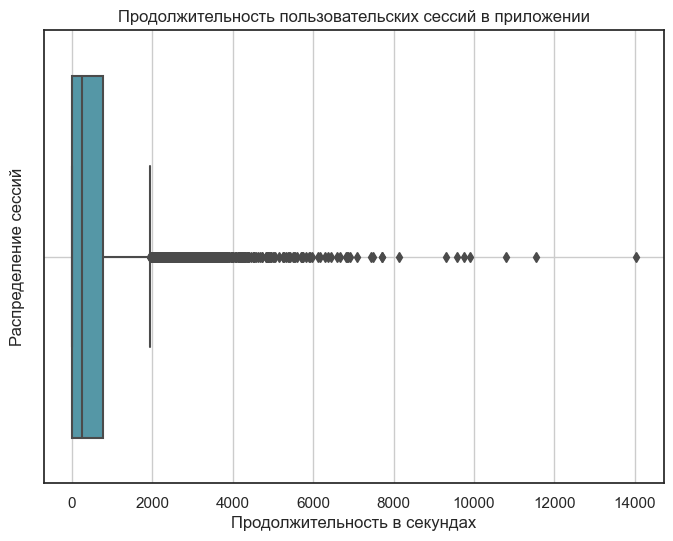

In [84]:
#ящик с усами
plt.figure(figsize=(8, 6), dpi=100)
palette = sns.color_palette("Spectral_r")
sns.boxplot(data=sessions, x="session_sec",  palette=palette)
plt.grid(True)
plt.title('Продолжительность пользовательских сессий в приложении')
plt.xlabel('Продолжительность в секундах') # подписи осей средствами matplotlib
plt.ylabel('Распределение сессий') # подписи осей средствами matplotlib
plt.show()

In [85]:
int(2000/60)

33

Итого, проанализировав все сессии можно заключить следующиее - подавляющее большинство сессий укладываются в 33 минуты (все что больше - является аномальными). 
Средняя продолжительность 1 сессии = 9 минут 26 секунд, медианная = 4 минуты 19 секунд. 
Если бы мы ранее в качестве перерыва между сессиями взяли интервал в 5 -10 минут, скорей всего результат был бы точнее. 

#### Определить среднее количество сессий на одного пользователя

In [86]:
avg_sessions = sessions.groupby('user_id', as_index = False)['session_id'].agg('nunique').sort_values(by = 'session_id')
avg_sessions

user_id  session_id
2146  80a9887a-d45f-44a2-9473-1446f68b9c16           1
2040  7a8d8ffa-62a1-4c29-bb4c-98659c52f704           1
2041  7a9109a8-7b24-4cdc-a0c9-badb07548c59           1
2042  7a97a344-0a02-4916-918f-de1e72b22654           1
2044  7aadb909-92da-42ff-8a7d-e7caae129338           1
...                                    ...         ...
1668  6383ff6a-04b8-4562-a98f-bb4f760d3c39          46
3162  be1449f6-ca45-4f94-93a7-ea4b079b8f0f          55
401   1580911b-65db-4f1a-be7e-1ca39becac30          58
3397  cb36854f-570a-41f4-baa8-36680b396370          79
615   21230dd9-2f7f-4b77-a436-43d4d10388e0         116

[4293 rows x 2 columns]

Посмотрим распределение данных на гистрограмме и ящике с усами.

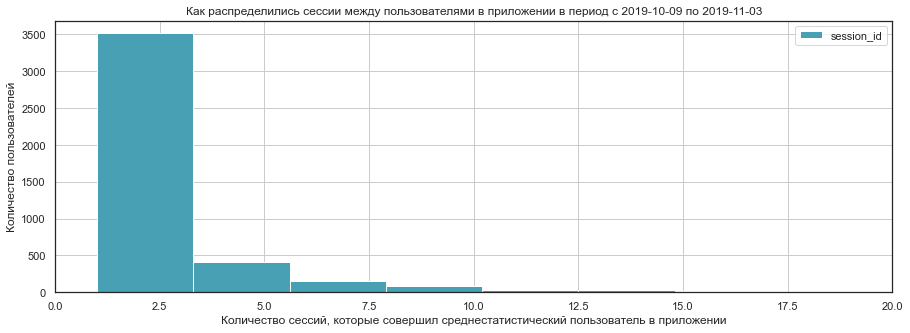

In [87]:
#строим гистограмму
avg_sessions.plot(kind = 'hist', bins=50, figsize = (15,5));
plt.xlim(0,20)
plt.grid(True);
plt.title("Как распределились сессии между пользователями в приложении в период с 2019-10-09 по 2019-11-03");
plt.xlabel('Количество сессий, которые совершил среднестатистический пользователь в приложении') 
plt.ylabel('Количество пользователей') 
plt.show();


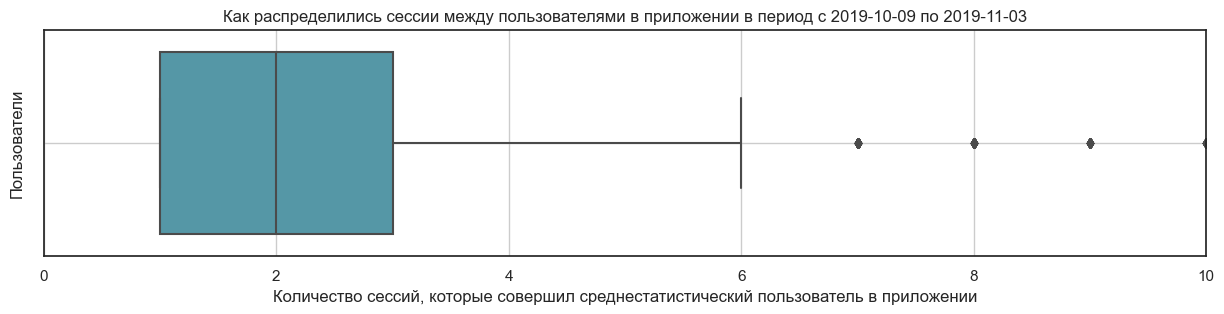

In [88]:
#ящик с усами
plt.figure(figsize=(15, 3), dpi=100);
palette = sns.color_palette("Spectral_r")
sns.boxplot(data=avg_sessions, x="session_id",  palette=palette);
plt.grid(True);
plt.xlim(0,10)
plt.title("Как распределились сессии между пользователями в приложении в период с 2019-10-09 по 2019-11-03");
plt.xlabel('Количество сессий, которые совершил среднестатистический пользователь в приложении') 
plt.ylabel('Пользователи')
plt.show();

Получается, что за период 2019-10-09 по 2019-11-03 подавляющее большинство пользователей (≈ 3500 шт) совершило по 1-3 сессии. Пользователи, которые совершили больше 6 сессий - считаем за аномалию. 

#### Проанализировать, сколько в среднем длится сессия, в которой пользователь совершил целевое дейсвие

In [89]:
target_time = sessions.query('target_event==True')

In [90]:
print(f'Медианное время одной пользовательской сессии в приложении = {target_time.session_life.median()}')
print(f'Среднее время одной пользовательской сессии в приложении = {target_time.session_life.mean()}')

Медианное время одной пользовательской сессии в приложении = 0 days 00:07:28.500000
Среднее время одной пользовательской сессии в приложении = 0 days 00:13:29.400968783


Любопытно, что среднее и медианное время сессии увеличилось, причем не на много - всего на 3-4 минуты. Я предполагала, что увеличение будет больше. Посмотрим, как данные распределяются на графике.

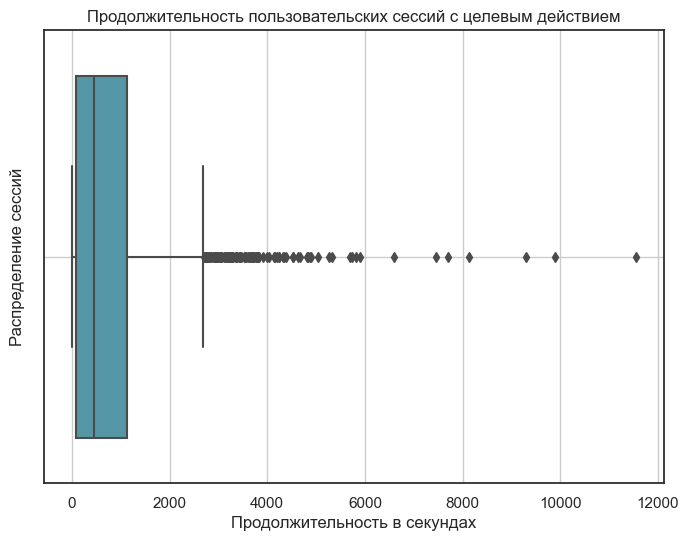

In [91]:
#ящик с усами
plt.figure(figsize=(8, 6), dpi=100)
palette = sns.color_palette("Spectral_r")
sns.boxplot(data=target_time, x="session_sec",  palette=palette)
plt.grid(True)
plt.title('Продолжительность пользовательских сессий с целевым действием')
plt.xlabel('Продолжительность в секундах') # подписи осей средствами matplotlib
plt.ylabel('Распределение сессий') # подписи осей средствами matplotlib
plt.show()

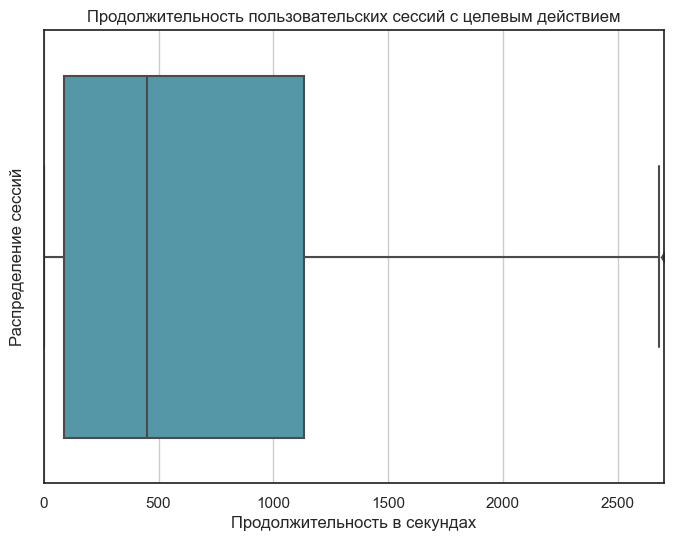

In [92]:
#ящик с усами
plt.figure(figsize=(8, 6), dpi=100)
palette = sns.color_palette("Spectral_r")
sns.boxplot(data=target_time, x="session_sec",  palette=palette)
plt.grid(True)
plt.title('Продолжительность пользовательских сессий с целевым действием')
plt.xlabel('Продолжительность в секундах') # подписи осей средствами matplotlib
plt.ylabel('Распределение сессий') # подписи осей средствами matplotlib
plt.xlim(0,2700)
plt.show()

In [93]:
2700/60

45.0

In [94]:
target_time.session_sec.describe()

count     1858.000000
mean       809.400969
std       1061.548506
min          0.000000
25%         88.000000
50%        448.500000
75%       1131.750000
max      11543.000000
Name: session_sec, dtype: float64

Наши подсчеты были верны, все сессии по продолжительности увеличились, теперь они могут длится до 45 минут, все что выше - считаем аномальными сессиями. 50 % пользователей делают свой выбор от 1,5 до 18 минут. Конечно, не стоит забывать, что сессии разные, есть те, что состоят только из целевых действий например.

#### Проанализировать, как различаются время между распространенными событиями пользователей в рамках сессии (посчитать среднее)

Ранее мы смотрели популярные события в разрезе пользователей, теперь проанализируем тоже самое, но в разрезе сессий.

In [95]:
top_event_session = users.groupby('event_name', as_index=False)['session_id'].agg({'session_id':'nunique'}).sort_values(by='session_id', ascending = False)

In [96]:
top_event_session['session_%'] = round(top_event_session['session_id'] / users.session_id.nunique() *100,1).astype(str) + ' %'
top_event_session

event_name  session_id session_%
14      tips_show        6719    58.2 %
5     photos_show        2711    23.5 %
4             map        2209    19.1 %
2   contacts_show        1858    16.1 %
6        search_1        1714    14.9 %
0     advert_open        1330    11.5 %
10       search_5         952     8.3 %
9        search_4         653     5.7 %
3   favorites_add         524     4.5 %
13     tips_click         428     3.7 %
11       search_6         422     3.7 %
1   contacts_call         323     2.8 %
7        search_2         307     2.7 %
8        search_3         305     2.6 %
12       search_7         201     1.7 %

In [97]:
#столбчатая диаграмма популярности разных типов событий в разрезе сессий

fig = px.bar(top_event_session, 
             x='event_name', 
             y='session_id', 
             text = 'session_%', 
             color = 'event_name',
             labels = {'event_name':'Тип события', 
                       'session_id':'Количество сессий',
                      'event_time':'Количество таких действий по всем пользователям',
                      'session_%':'% сессий с выбранным событием'},
             title='Популярность разных действий в приложении в разрезе пользовательских сессий') 
fig.update_xaxes(title_text = ' Типы событий, совершаемые в приложении ')
fig.update_yaxes(title_text = 'Количество совершенных сессий')
fig.show();

Вообщем-то , популярность событий, совершаемых в разрезе сессий никак не отличается от аналогичного графика по уникальным пользователям - разве что, показатели стали меньше. Значит для анализа выберем несколько пар событий из первой пятерки, без учета показа рекомендаций. 

Например, такие:
1. map - advert_open
2. search_1 - advert_open
3. advert_open - contacts_show
4. advert_open - tips_show
5. photos_show - favorites_add

Создадим функцию с параметрами event1 и event2. 
На основе сессий, в которых встречаются оба события, функция должна посчитать через сколько времени после наступления события event1 - наступило событие event2. 

In [98]:
#ф-ия считает среднее время наступления второго события в паре (event1, event2)
def time_between_events(event1, event2):
    temp_list = []
    
    #находим список сессий, в которых участвуют оба события
    s1 = list(users.query('event_name==@event1')['session_id'].unique())
    s2 = list(users.query('event_name==@event2')['session_id'].unique())
    sessions_list = sorted(list(set(s1) & set(s2)))
    
    #создаем датафрейм с выбранными сессиями
    db = users.query('session_id in @sessions_list').sort_values(by=['session_id','event_time'])
    #display(db)
    
    #проходим циклом по сессиям
    for i in sessions_list:
        #ищем время 1го event1
        time1 = db.query('(event_name==@event1) & (session_id ==@i)').event_time.min()
        
        #формируем список всех event2
        temp = db.query('(event_name==@event2) & (session_id ==@i)')['event_time']
        #выбираем время первого event2 из тех, что по времени наступили позже event1
        for t in list(temp):
            if t > time1:
                time2 = t
                break
            else:
                time2 = pd.NaT
        #добавляем в список разницу между событиями в каждой сессии
        temp_list.append(pd.Timedelta(time2-time1))
    
    #формируем датафрейм
    db_temp = pd.DataFrame({'session_id':sessions_list, 'time_beetween_events':temp_list}).dropna()
    print('Медианное время между событиями', event1,'и',event2, 'равно', db_temp.time_beetween_events.median() )
    print('Среднее время между событиями', event1,'и',event2, 'равно', db_temp.time_beetween_events.mean() )


Теперь выполним проверку на наших парах:

In [99]:
time_between_events('map','advert_open')

Медианное время между событиями map и advert_open равно 0 days 00:01:36
Среднее время между событиями map и advert_open равно 0 days 00:03:47.295208655


In [100]:
time_between_events('search_1','advert_open')

Медианное время между событиями search_1 и advert_open равно 0 days 00:07:35
Среднее время между событиями search_1 и advert_open равно 0 days 00:12:28.962962962


In [101]:
time_between_events('advert_open','contacts_show')

Медианное время между событиями advert_open и contacts_show равно 0 days 00:02:55
Среднее время между событиями advert_open и contacts_show равно 0 days 00:06:11.330434782


In [102]:
time_between_events('advert_open','tips_show')

Медианное время между событиями advert_open и tips_show равно 0 days 00:00:08
Среднее время между событиями advert_open и tips_show равно 0 days 00:01:04.751626898


In [103]:
time_between_events('photos_show','favorites_add')

Медианное время между событиями photos_show и favorites_add равно 0 days 00:03:40
Среднее время между событиями photos_show и favorites_add равно 0 days 00:06:39.952662721


In [104]:
time_between_events('tips_show','tips_click')

Медианное время между событиями tips_show и tips_click равно 0 days 00:06:03
Среднее время между событиями tips_show и tips_click равно 0 days 00:10:23.518005540


Посмотрев результаты расчетов, можно сделать сделующие выводы:
- если пользователь открыл карту объявлений, то в среднем через 3:47 минуты произойдет открытие карточки товара. В то время как в обычном поиске - только через 12:28. Мне кажется, это очень большая разница между релевантными событиями. 
- если пользователь открыл карточку товара, то рекомендации он увидит в среднем через 1:04 минуты. Наверное, это хороший показатель, чтобы не ущемлять обычные объявления рекомендованными.
- если пользователь посмотрел фотографии товара и они ему понравились, то в избранное он добавит товар только через 6:39. мне кажется, такое событие должно происходить раньше, возможно стоит проанализировать это более детально. 

### Выделить несколько сценариев достижения ключевого действия. Построить воронки

Самый лучший способ предстаить основные сценарии пользователей - это визуализировать данные с помощью диаграммы Сэнкея (https://habr.com/ru/post/566568/). Но сначала нам нужно подготовить исходные данные - нас интересуют только те сценарии, которые заканчиваются целевым действием, т.е. просмотром контактов. Поэтому для начала подготовим датасет с целевыми сессиями пользователей.

#### Подготовка датасета целевых сессий

In [105]:
filtr = users.query('event_name=="contacts_show"')['session_id'].unique()
targets_step = users.query('session_id in @filtr').sort_values(by=['session_id','event_time'])[['event_time','event_name','session_id']]
targets_step

event_time     event_name  session_id
16    2019-10-20 18:49:24       search_1           6
17    2019-10-20 18:59:22    photos_show           6
18    2019-10-20 19:03:02  favorites_add           6
19    2019-10-20 19:04:16       search_1           6
20    2019-10-20 19:17:18  contacts_show           6
...                   ...            ...         ...
33667 2019-11-03 14:46:13      tips_show       11535
33668 2019-11-03 15:36:01      tips_show       11536
33669 2019-11-03 15:48:05  contacts_show       11536
33670 2019-11-03 15:50:01      tips_show       11536
33671 2019-11-03 15:51:57  contacts_show       11536

[8769 rows x 3 columns]

В текущей задаче дубликаты в событиях нам будут мешать, поэтому мы можем спокойно их удалить в рамках сессий.

In [106]:
targets_step = targets_step.drop_duplicates(['event_name','session_id'], keep='first')\
.sort_values(by=['session_id','event_time'])\
.reset_index(drop=True)
targets_step

event_time     event_name  session_id
0    2019-10-20 18:49:24       search_1           6
1    2019-10-20 18:59:22    photos_show           6
2    2019-10-20 19:03:02  favorites_add           6
3    2019-10-20 19:17:18  contacts_show           6
4    2019-10-20 19:17:24  contacts_call           6
...                  ...            ...         ...
4561 2019-11-02 19:26:07  contacts_show       11534
4562 2019-11-03 14:32:55      tips_show       11535
4563 2019-11-03 14:33:47  contacts_show       11535
4564 2019-11-03 15:36:01      tips_show       11536
4565 2019-11-03 15:48:05  contacts_show       11536

[4566 rows x 3 columns]

Если выборочно посмотреть сессии пользователей, то можно заметить , что очень часто они начинаются с различных видов поиска. Чтобы сократить число шагов в цепочке объединим группу поиска в одну категорию.

In [107]:
targets_step = targets_step.replace(to_replace=['search_1','search_2','search_3','search_4','search_5','search_6','search_7'], value="search")
targets_step = targets_step.drop_duplicates(['event_name','session_id'], keep='first')
targets_step

event_time     event_name  session_id
0    2019-10-20 18:49:24         search           6
1    2019-10-20 18:59:22    photos_show           6
2    2019-10-20 19:03:02  favorites_add           6
3    2019-10-20 19:17:18  contacts_show           6
4    2019-10-20 19:17:24  contacts_call           6
...                  ...            ...         ...
4561 2019-11-02 19:26:07  contacts_show       11534
4562 2019-11-03 14:32:55      tips_show       11535
4563 2019-11-03 14:33:47  contacts_show       11535
4564 2019-11-03 15:36:01      tips_show       11536
4565 2019-11-03 15:48:05  contacts_show       11536

[4439 rows x 3 columns]

#### Расширение датасета новыми данными

Теперь добавим в наш датасет новые данные, необходимые для построения диаграммы:
1. определим пары source-target, а также пронумеруем эти пары в соответствии с временем наступления события.

In [108]:
# добавляем шаги событий
targets_step['step'] = targets_step.groupby('session_id').cumcount() + 1
targets_step.head(2)

event_time   event_name  session_id  step
0 2019-10-20 18:49:24       search           6     1
1 2019-10-20 18:59:22  photos_show           6     2

In [109]:
# добавляем узлы-источники и целевые узлы. узлы-источники - это сами события
targets_step['source'] = targets_step['event_name']

# добавляем целевые узлы
targets_step['target'] = targets_step.groupby('session_id')['source'].shift(-1)

#удаляем лишний столбец
targets_step = targets_step.drop(['event_name'], axis=1)
targets_step.head(2)

event_time  session_id  step       source         target
0 2019-10-20 18:49:24           6     1       search    photos_show
1 2019-10-20 18:59:22           6     2  photos_show  favorites_add

2. Необходимо определеить максимальное число шагов, с которым будем работать. Нашим конечным событием будет contacts_show, чтобы понять, сколько шагов в среднем до него идти - посмотрим гистограмму. 

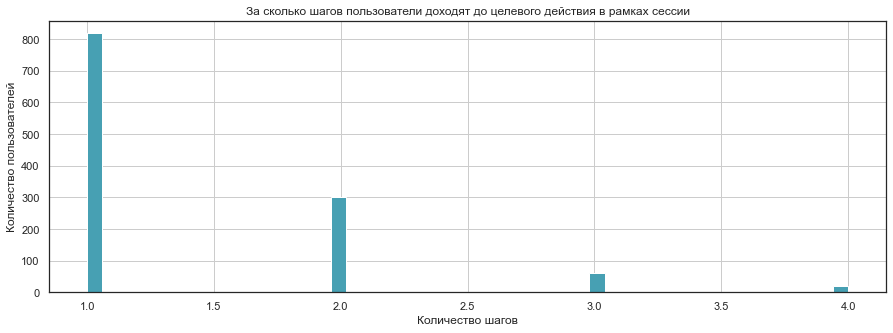

In [110]:
#строим гистограмму
targets_step.query('target=="contacts_show"')['step'].plot(kind = 'hist', bins=50, figsize = (15,5));
plt.grid(True);
plt.title("За сколько шагов пользователи доходят до целевого действия в рамках сессии");
plt.xlabel('Количество шагов') 
plt.ylabel('Количество пользователей') 
plt.show();


По графику видно, что целевое действие достигается максимум за 4 шага, а то и за 2. Определим наш лимит - в 4 шага.

In [111]:
# удалим все пары source-target, шаг которых превышает 4
targets_step = targets_step.query('step<5').reset_index(drop=True)
targets_step


event_time  session_id  step         source         target
0    2019-10-20 18:49:24           6     1         search    photos_show
1    2019-10-20 18:59:22           6     2    photos_show  favorites_add
2    2019-10-20 19:03:02           6     3  favorites_add  contacts_show
3    2019-10-20 19:17:18           6     4  contacts_show  contacts_call
4    2019-10-20 19:57:15           7     1    photos_show  contacts_show
...                  ...         ...   ...            ...            ...
4382 2019-11-02 19:26:07       11534     2  contacts_show            NaN
4383 2019-11-03 14:32:55       11535     1      tips_show  contacts_show
4384 2019-11-03 14:33:47       11535     2  contacts_show            NaN
4385 2019-11-03 15:36:01       11536     1      tips_show  contacts_show
4386 2019-11-03 15:48:05       11536     2  contacts_show            NaN

[4387 rows x 5 columns]

3. Чтобы выдержать последовательность действий - создадим скозные индексы для source. Создадим словарь, в котором ключи - это шаги, а значения - словари со списком названий source и соответствующих им индексов. Затем для каждого шага объединяем имена и индексы в еще один вложенный словарь. Все вложенные списки и словари потребуются в дальнейшем для генерации меток, подписей и размера каналов между source и target.

In [112]:
  def get_source_index(df):
    
    """Функция генерации индексов source

    Args:
        df (pd.DataFrame): исходная таблица с признаками step, source, target.
    Returns:
        dict: словарь с индексами, именами и соответсвиями индексов именам source.
    """
    
    res_dict = {}
    
    count = 0
    # получаем индексы источников
    for no, step in enumerate(df['step'].unique().tolist()):
        # получаем уникальные наименования для шага
        res_dict[no+1] = {}
        res_dict[no+1]['sources'] = df[df['step'] == step]['source'].unique().tolist()
        res_dict[no+1]['sources_index'] = []
        for i in range(len(res_dict[no+1]['sources'])):
            res_dict[no+1]['sources_index'].append(count)
            count += 1
            
    # соединим списки
    for key in res_dict:
        res_dict[key]['sources_dict'] = {}
        for name, no in zip(res_dict[key]['sources'], res_dict[key]['sources_index']):
            res_dict[key]['sources_dict'][name] = no
    return res_dict
  

# создаем словарь
source_indexes = get_source_index(targets_step)
source_indexes[1]

{'sources': ['search',
  'photos_show',
  'contacts_show',
  'map',
  'tips_show',
  'favorites_add',
  'advert_open',
  'tips_click'],
 'sources_index': [0, 1, 2, 3, 4, 5, 6, 7],
 'sources_dict': {'search': 0,
  'photos_show': 1,
  'contacts_show': 2,
  'map': 3,
  'tips_show': 4,
  'favorites_add': 5,
  'advert_open': 6,
  'tips_click': 7}}

4. Зададим цвета для графика с помощью случайной генерации rgba

In [113]:
def colors_for_sources():
    
    # словарь, в который сложим цвета в соответствии с индексом
    colors_dict = {}
    
    # генерим случайные цвета
    for label in targets_step['source'].unique():
        r, g, b = np.random.randint(255, size=3)            
        colors_dict[label] = f'rgba({r}, {g}, {b}, 1)'
            
    return colors_dict
  
  
# получаем словарь с цветами для каждого вида источника
colors_dict = colors_for_sources()
colors_dict

{'search': 'rgba(27, 176, 109, 1)',
 'photos_show': 'rgba(83, 249, 30, 1)',
 'favorites_add': 'rgba(246, 239, 63, 1)',
 'contacts_show': 'rgba(99, 52, 56, 1)',
 'contacts_call': 'rgba(23, 140, 98, 1)',
 'tips_show': 'rgba(105, 243, 84, 1)',
 'map': 'rgba(0, 70, 158, 1)',
 'advert_open': 'rgba(211, 17, 200, 1)',
 'tips_click': 'rgba(22, 28, 38, 1)'}

5. Создадим словарь с данными, которые потребуются для отрисовки диаграммы:<br>
   - sources - список с индексами source;
   - targets - список с индексами target;
   - values - количество уникальных сессий, содержаших переход между узлами source-target ("объем" потока между узлами);
   - labels - названия узлов;
   - colors_labels - цвет узлов;
   - link_color - цвет потоков между узлами;
   - link_text - дополнительная информация.

Создадим функцию для подсчета уникальных сессий в %

In [114]:
def percent_users(sources, targets, values):
    
    """
    Расчет уникальных id в процентах (для вывода в hover text каждого узла)
    
    Args:
        sources (list): список с индексами source.
        targets (list): список с индексами target.
        values (list): список с "объемами" потоков.
        
    Returns:
        list: список с "объемами" потоков в процентах
    """
    
    # объединим источники и метки и найдем пары
    zip_lists = list(zip(sources, targets, values))
    
    new_list = []
    
    # подготовим список словарь с общим объемом трафика в узлах
    unique_dict = {}
    
    # проходим по каждому узлу
    for source, target, value in zip_lists:
        if source not in unique_dict:
            # находим все источники и считаем общий трафик
            unique_dict[source] = 0
            for sr, tg, vl in zip_lists:
                if sr == source:
                    unique_dict[source] += vl
                    
    # считаем проценты
    for source, target, value in zip_lists:
        new_list.append(round(100 * value / unique_dict[source], 1))
    
    return new_list

Теперь создадим итоговый словарь с данными для отрисовки диаграммы с помощью Plotly 

In [115]:

def lists_for_plot(source_indexes=source_indexes, colors=colors_dict, frac=10):
    
    """
    Создаем необходимые для отрисовки диаграммы переменные списков и возвращаем
    их в виде словаря
    
    Args:
        source_indexes (dict): словарь с именами и индексами source.
        colors (dict): словарь с цветами source.
        frac (int): ограничение на минимальный "объем" между узлами.
        
    Returns:
        dict: словарь со списками, необходимыми для диаграммы.
    """
    
    sources = []
    targets = []
    values = []
    labels = []
    link_color = []
    link_text = []

    # проходим по каждому шагу
    for step in tqdm(sorted(targets_step['step'].unique()), desc='Шаг'):
        if step + 1 not in source_indexes:
            continue

        # получаем индекс источника
        temp_dict_source = source_indexes[step]['sources_dict']

        # получаем индексы цели
        temp_dict_target = source_indexes[step+1]['sources_dict']

        # проходим по каждой возможной паре, считаем количество таких пар
        for source, index_source in tqdm(temp_dict_source.items()):
            for target, index_target in temp_dict_target.items():
                # делаем срез данных и считаем количество id            
                temp_df = targets_step[(targets_step['step'] == step)&(targets_step['source'] == source)&(targets_step['target'] == target)]
                value = len(temp_df)
                # проверяем минимальный объем потока и добавляем нужные данные
                if value > frac:
                    sources.append(index_source)
                    targets.append(index_target)
                    values.append(value)
                    # делаем поток прозрачным для лучшего отображения
                    link_color.append(colors[source].replace(', 1)', ', 0.2)'))
                    
    labels = []
    colors_labels = []
    for key in source_indexes:
        for name in source_indexes[key]['sources']:
            labels.append(name)
            colors_labels.append(colors[name])
            
    # посчитаем проценты всех потоков
    perc_values = percent_users(sources, targets, values)
    
    # добавим значения процентов для howertext
    link_text = []
    for perc in perc_values:
        link_text.append(f"{perc}%")
    
    # возвратим словарь с вложенными списками
    return {'sources': sources, 
            'targets': targets, 
            'values': values, 
            'labels': labels, 
            'colors_labels': colors_labels, 
            'link_color': link_color, 
            'link_text': link_text}
  

# создаем словарь
data_for_plot = lists_for_plot()

100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 112.65it/s]

Шаг: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 17.02it/s]


#### Построение диаграммы Сэнкея

Приступим к созданию объекта диаграммы. Сохраним его в отдельную переменную senkey_diagram для дальнейшего сохранения или публикации:

In [116]:
def plot_senkey_diagram(data_dict=data_for_plot):    
    
    """
    Функция для генерации объекта диаграммы Сенкей 
    
    Args:
        data_dict (dict): словарь со списками данных для построения.
        
    Returns:
        plotly.graph_objs._figure.Figure: объект изображения.
    """
    
    fig = go.Figure(data=[go.Sankey(
        domain = dict(
          x =  [0,1],
          y =  [0,1]
        ),
        orientation = "h",
        valueformat = ".0f",
        node = dict(
          pad = 50,
          thickness = 15,
          line = dict(color = "black", width = 0.1),
          label = data_dict['labels'],
          color = data_dict['colors_labels']
        ),
        link = dict(
          source = data_dict['sources'],
          target = data_dict['targets'],
          value = data_dict['values'],
          label = data_dict['link_text'],
          color = data_dict['link_color']
      ))])
    fig.update_layout(title_text="Карта пользовательских сценариев достижения целевого действия в приложении", font_size=10)
    
    # возвращаем объект диаграммы
    return fig
  

# сохраняем диаграмму в переменную
senkey_diagram = plot_senkey_diagram()
senkey_diagram.show()

Теперь мы можем точно определеить основные сценарии достижения ЦД, на диаграмме они предсталены более чем наглядно:
1. tips_show - contacs_show
2. photos_show - contacs_show
3. search - contacs_show
4. search - tips_show - contacs_show
5. map - tips_show - contacs_show

Так же на диаграмме видно, что определенная часть сессий начинаеся с дейтсвий contact_show, photos_show, advent_open - это своего рода не полные сценарии, так как они продолжают ранее разорванную сессию.

#### Построение воронок основных сценариев

Создадим функцию, которая принимает шаги событий, а на выходе выдает датафрейм, который содержит конверсию пользователей между текущим и предыдущим шагом.

In [117]:
event_funnel = users.replace(to_replace=['search_2','search_3','search_4','search_5','search_6','search_7'],value="search")
def funnel (*events): 
    #список событий
    event_list = []
    
    #список содержит конверсию пользователей из шага в шаг
    steps = []
    
    #бежим по шагам цепочки, максимум в наших сценариях заложено 4 шага
    for i,event in enumerate(events):
        if i==0:
            step = event_funnel.query('event_name==@event').user_id.nunique()
            s1 = list(event_funnel.query('event_name==@event').user_id.unique())
        elif i==1:
            s2 = list(event_funnel.query('event_name==@event').user_id.unique())
            step = len(set(s1) & set(s2))
        elif i==2:
            s3 = list(event_funnel.query('event_name==@event').user_id.unique())
            step = len(set(s1) & set(s2) & set(s3))
        else:
            s4 = list(event_funnel.query('event_name==@event').user_id.unique())
            step = len(set(s1) & set(s2) & set(s3) & set(s3))
        event_list.append(event)
        steps.append(step)

    #создаем датафрейм
    df = pd.DataFrame(columns = ['event_name','users'])
    df['event_name'] = event_list      
    df['users'] = steps
    
    
    #строим фигуру воронки
    fig = go.Figure(go.Funnel(
        y = df['event_name'],
        x = df['users'],
        textposition = "inside",
        textinfo = "value+percent initial",
        opacity = 0.8, marker = {"color": ["DodgerBlue", "DeepSkyBlue", "Turquoise", "Aquamarine"],
        "line": {"color": ["wheat", "wheat", "blue", "wheat", "wheat"]}},
        connector = {"line": {"color": "royalblue", "dash": "dot", "width": 2}})
        )
    #добавляем подписи
    t = (' &#8594; '.join(event_list))
    title = "Сколько пользователей успешно прошло сценарий: " + t
    
    fig.update_layout(title=title,
                      xaxis_title="Количество пользователей, прошедших шаг, в %",
                      yaxis_title="Действия пользователей")

    fig.show();
    
    

Теперь посмотрим воронки для всех ключевых сценариев:

In [118]:
#1 сценарий
funnel('tips_show','contacts_show')

In [119]:
#2 сценарий
funnel('photos_show','contacts_show')

In [120]:
#3 сценарий
funnel('search','contacts_show')


In [121]:
#4 сценарий
funnel('search','tips_show','contacts_show')


In [122]:
#5 сценарий
funnel('map','tips_show','contacts_show')


В целом, если посмотреть все сценарии, то они отрабатывают хорошо и приносят конверсию перехода в ЦД 15-31% от первоначального шага. Правда, вряд ли можно доверять сценариям, которые начинаются с tips_show или photos_show - они кажутся неполными.
В остальных цепочках идет разделение пользователей на тех кто предпочитает карту и тех, кто выбирает обычный поиск. Конверсия в ЦД больше у тех, кто начинает путь с карты.

### Проанализировать из каких источников больше всего приходит пользователей.

Подготовим сводную табличку с данными по источникам.

In [123]:
df_sources = sources.groupby('source',as_index = False).user_id.agg('nunique')
df_sources.columns = ['sourse','all_users']
df_sources = df_sources.sort_values(by='all_users', ascending = False).reset_index(drop = True)
df_sources

sourse  all_users
0  yandex       1934
1   other       1230
2  google       1129

Лидеры определились. Теперь добавим в таблицу информацию о кол-ве целевых пользователей для каждого ресурса.

In [124]:
df_convers = sources.merge(users).query('event_name=="contacts_show"').groupby('source',as_index = False).user_id.agg('nunique')
df_convers

source  user_id
0  google      275
1   other      228
2  yandex      478

In [125]:
#итоговая табличка
df_sources['target_users'] = df_convers['user_id']
df_sources['not_target_users'] = df_sources['all_users'] - df_sources['target_users']
df_sources

sourse  all_users  target_users  not_target_users
0  yandex       1934           275              1659
1   other       1230           228              1002
2  google       1129           478               651

Чтобы построить хороший график, добавим в таблицу информацию о процентном соотношении всех показателей.

In [126]:
df_sources['all_users_%'] = df_sources['sourse'] + ' / ' + round(df_sources['all_users']/df_sources['all_users'].sum() *100,2).astype(str) + '%'
df_sources['target_users_%'] =  round(df_sources['target_users'] / df_sources['all_users']*100,2).astype(str) + '%'
df_sources['not_target_users_%'] =  round(df_sources['not_target_users'] / df_sources['all_users']*100,2).astype(str) + '%'
df_sources
df_sources

sourse  all_users  target_users  not_target_users      all_users_%  \
0  yandex       1934           275              1659  yandex / 45.05%   
1   other       1230           228              1002   other / 28.65%   
2  google       1129           478               651   google / 26.3%   

  target_users_% not_target_users_%  
0         14.22%             85.78%  
1         18.54%             81.46%  
2         42.34%             57.66%

In [127]:
#стром столбчатую диаграмму
fig = px.bar(df_sources, 
             x='all_users_%', 
             y=['target_users','not_target_users'],
             color_discrete_sequence=['#fed884','#4ea7b0'],
             labels={'variable':'Типы пользователей', 
                     'value':'Уникальных пользователей',
                    'all_users_%':'Источник перехода в приложение'},
             height=600)
fig.update_layout(title='Из каких источников больше всего приходит пользователей в приложение ')
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})


#подписвыаем проценты на столбцах
texts = list()
texts = [df_sources['target_users_%'].tolist(),df_sources['not_target_users_%'].tolist()]
for i, t in enumerate(texts):
    fig.data[i].text = t 
    fig.data[i].textposition = 'outside'

#меняем имена в легенде
series_names = ["Целевые", "Нецелевые"]
for idx, name in enumerate(series_names):
    fig.data[idx].name = name
fig.show()

Очевидно, что больше всего пользователей, а именно 45.1%, переходят в приложение из yandex, но вот целевых среди них не так уж и много, всего 14,22%. Всех больше целевых пользователей приходит из google, стоит подумать о том, как увеличить приток людей именно с этого источника.

## Выдвижение и проверка гипотез

### Проверка гипотезы № 1 - переход в карточку рекомендаций влияет на конверсию в целевое действие

Есть две группы пользователей: в 1-ой пользователи хотя бы раз совершали переход по увиденным рекомендациями, во 2-ой пользователи видели рекомендации, но ни разу не переходили по ним. 
Нулевая гипотеза: конверсия в просмотры контактов не различается между группами. Альтернативная гипотеза: конверсия в просмотры контаков различается в группах.

Чтобы проверить нулевую гипотезу, нам необходимо проверить статистическую значимость отличий двух рассматриваемых групп в разрезе совершения ЦД пользователями из обеих групп. Делать мы это будем по формуле ниже:
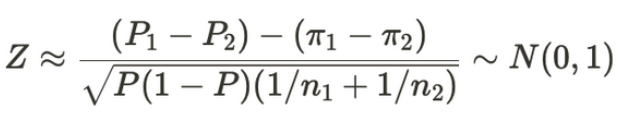

Подготовим все необходиме показатели:

In [128]:
# сколько пользователей в группе 1(совершили tips_show и tips_click хотя бы 1 раз по каждому событию)
users_tips_click = list(users.query('event_name=="tips_click"').user_id.unique())
users_tips_show = list(users.query('event_name=="tips_show"').user_id.unique())

show_click_tips = list(set(users_tips_click) & set(users_tips_show))
n1 = len(show_click_tips)
n1

297

In [129]:
91/297

0.3063973063973064

In [130]:
# сколько пользователей в группе 2(совершили tips_show, но ни разу не совершали tips_click)
show_notclick_tips = list(set(users_tips_show) - set(users_tips_click))
n2 = len(show_notclick_tips)
n2

2504

In [131]:
#сколько пользователей совершили ЦД в группе 1
convrs_users = list(users.query('event_name=="contacts_show"')['user_id'].unique())
p1 = len(list(set(show_click_tips) & set(convrs_users)))
p1

91

In [132]:
#Сколько пользователей совершили ЦД в группе 2
p2 = len(list(set(show_notclick_tips) & set(convrs_users)))
p2

425

Все данные готовы, проверку статзначимости обернем в функцию:

In [133]:
def stat_znachimost(alpha, trials, successes):
        
    alpha=alpha # критический уровень статистической значимости

    #список содержит размер выборки в группах
    trials = trials
    #список содержит количество успешных переходов на выбранный шаг воронки в группах
    successes = successes
    
    
    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]
    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    # разница пропорций в датасетах
    difference = p1 - p2 
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('')
    print('p-значение: ', p_value)
    

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )
        

In [134]:
#проверка гипотезы №1
stat_znachimost(alpha=0.05, trials = [n1,n2], successes = [p1,p2])


p-значение:  9.218316554537864e-09
Отвергаем нулевую гипотезу: между долями есть значимая разница


In [135]:
a = 9.218316554537864e-09
'{:.20f}'.format(a)

'0.00000000921831655454'

Проверка говорит о том, что переход в карточку рекомендаций все таки влияет на целевое действие пользователей.

### Проверка гипотезы №2 - добавление товара в избранное влияет на конверсию в целевое действие

Есть две группы пользователей: в 1ой - пользователи хотя бы раз добавляли товар в избранное, во 2ой - ни разу. 
Нулевая гипотеза: конверсия в просмотры контактов не различается между группами. Альтернативная гипотеза: конверсия в просмотры контаков различается в группах.

Проверку гипотезы будем делать аналогично предыдущему шагу - путем проверки стат. значимости двух групп в разрезе ЦД. 
Подготовим данные:

In [136]:
# сколько пользователей в группе 1(совершили favorites_add хотя бы 1 раз за все время)
users_favorites_add = list(users.query('event_name=="favorites_add"').user_id.unique())
n1 = len(users_favorites_add)
n1


351

In [137]:
# сколько пользователей в группе 2(ни разу не совершали favorites_add)
users_not_favorites_add = list(set(list(users.user_id.unique())) - set(users_favorites_add))
n2 = len(users_not_favorites_add)
n2

3942

In [138]:
#сколько пользователей совершили ЦД в группе 1
convrs_users = list(users.query('event_name=="contacts_show"')['user_id'].unique())
p1 = len(list(set(users_favorites_add) & set(convrs_users)))
p1

136

In [139]:
#сколько пользователей совершили ЦД в группе 2
convrs_users = list(users.query('event_name=="contacts_show"')['user_id'].unique())
p1 = len(list(set(users_not_favorites_add) & set(convrs_users)))
p1

845

Данные готовы, переходим к проверке гипотезы:

In [140]:
#проверка гипотезы №1
stat_znachimost(alpha=0.05, trials = [n1,n2], successes = [p1,p2])


p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница


Проверка говорит о том, что добаление товара в избранное так же влияет на целевое действие пользователей, так как различия в группах пользователей имеют статистическую значимость.

### Проверка гипотезы №3 - источник перехода в приложение никак не влияет на конверсию в целевое действие

Мы имеем три вида источника, 3 отдельные группы пользователей: 
- 1 группа (Y) = yandex
- 2 группа (G) = google
- 3 группа (O) = other

Нулевая гипотеза: конверсия в просмотры контактов одинакова для всех пользователей в независимости от источника перехода. Альтернативная гипотеза: конверсия в просмотры контаков отличается между пользователями разных источников.

Для проверки общей гипотезы нуобходимо сделать множественную проверку - сформируем 3 группы пар и для каждой выполним проверку стат.значимости в разрезе перехода в ЦД. 
- (Y,O)
- (Y,G)
- (O,G)

Чтобы результат был более точным, возьмем alpha = 0.01.

In [141]:
#Проверка стат. значимости групп (Y,O)
spisok=[True, True, False]
trials = list(df_sources[spisok]['all_users'])
successes = list(df_sources[spisok]['target_users'])
print('Проверка стат. значимости пары групп (Y,O)')
stat_znachimost(alpha=0.01, trials = trials, successes=successes)


Проверка стат. значимости пары групп (Y,O)

p-значение:  0.001205814954916562
Отвергаем нулевую гипотезу: между долями есть значимая разница


In [142]:
#Проверка стат. значимости групп (Y,G)
spisok=[True, False, True]
trials = list(df_sources[spisok]['all_users'])
successes = list(df_sources[spisok]['target_users'])
print('Проверка стат. значимости пары групп (Y,G)')
stat_znachimost(alpha=0.01, trials = trials, successes=successes)


Проверка стат. значимости пары групп (Y,G)

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница


In [143]:
#Проверка стат. значимости групп (O,G)
spisok=[False, True, True]
trials = list(df_sources[spisok]['all_users'])
successes = list(df_sources[spisok]['target_users'])
print('Проверка стат. значимости пары групп (O,G)')
stat_znachimost(alpha=0.01, trials = trials, successes=successes)

Проверка стат. значимости пары групп (O,G)

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница


Мы получили неожиданный результат, при проверке выяснилось, что все группы пользователей в разрезе конверсии в ЦД имеют статистически значимую разницу между собой, значит источник все таки влияет на конверсию!

## Подготовка презентации

Задача - подготовить небольшую презентацию в формате PDF, которая будет отражать основную суть и выводы исследования.

ссылка на презентацию будет приложена во второй итерации блокнота.

## Подготовка дашборда

<b> Задача - отобразить на дашборде следующие наборы данных:</b><br>

Набор №1 
Построить диаграмму распределения количества событий по типу события.
Добавить индикатор количества пользователей.
Добавить фильтр дашборда по дате совершения события.

Набор №2 
Построить диаграмму, отображающую количество событий по дням.
Построить гистограмму, отображающую количество пользователей, пришедших из разных источников.
Добавить фильтр дашборда по типу события. 


ссылка на дашборд: дашборд будет реализован на следующем этапе реализации исследования.

## Итоговый вывод исследования

1. Мы провели большое исследование, проанализировав данные о поведении почти 4300 уникальных пользователей в приложении за период с 2019-10-07 и по 2019-11-03. Наши пользователи проявляют цикличную активность с периодом в 7 дней, самый "спокойный день" - суббота, "самые активные" - вторник, среда. 
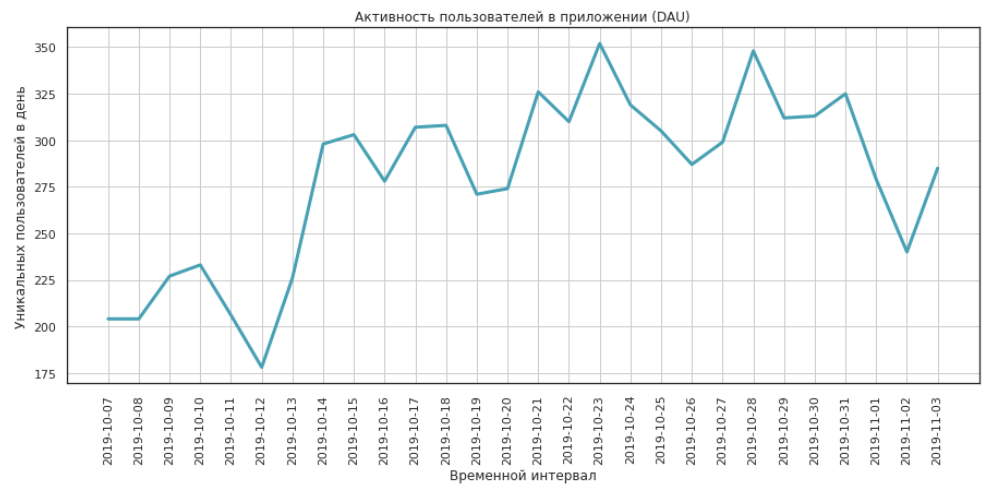

Целевое событие в течение дня чаще всего наступает в 13:00, 16:00 и 20:00.
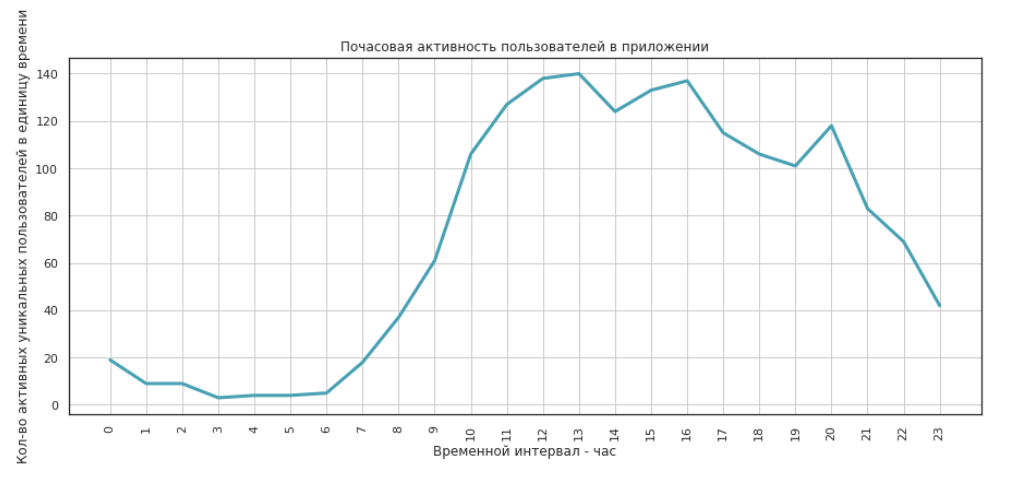

2. Сервис рекомендаций работает эффективно, 65.2 % всех пользователей видят рекомендации, среди тех, кто перешел в карточку рекомендации 30.5% пользователей совершают целевое действие, эти данные имеют статистическую значимость.


3. Целевые пользователи чаще других действий смотрят фотографии, ищут объявления через карту или обычный поиск(search_1) 
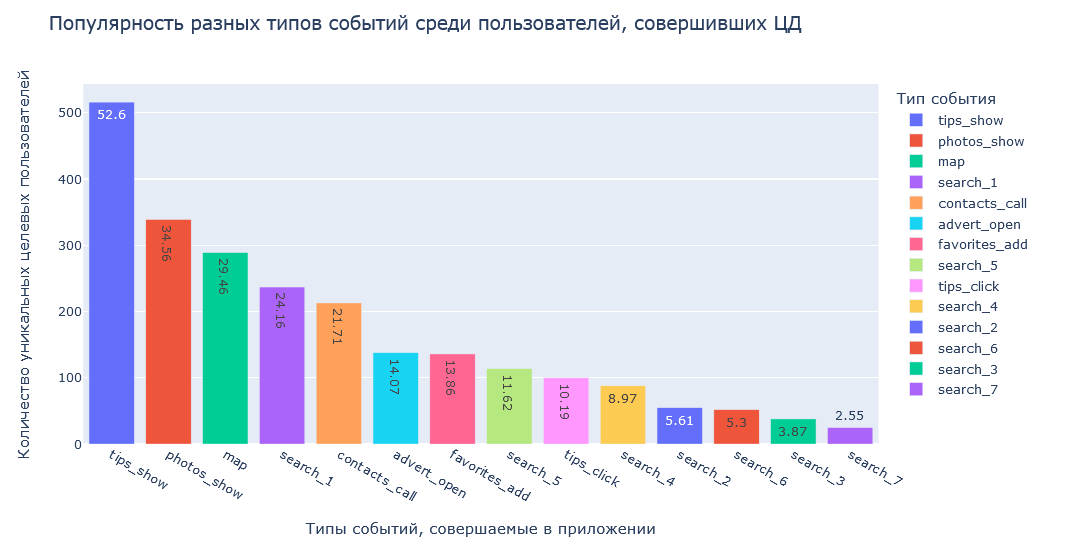

4. Средняя сессия пользователя в приложении длится чуть больше 9 минут, сессия, в которой наступает целевое действие, увеличивается в среднем до 13,5 минут. За период 2019-10-09 по 2019-11-03 подавляющее большинство пользователей (≈ 3500 шт) совершило по 1-3 сессии.<br> 

5. Было выявлено 5 пользовательских сценариев по достижению целевого действия в приложении:
    tips_show - contacs_show, 
    photos_show - contacs_show,
    search - contacs_show, 
    search - tips_show - contacs_show, 
    map - tips_show - contacs_show.
Все сценарии показывают хорошую конверсию перехода в ЦД (от 15 до 30%)
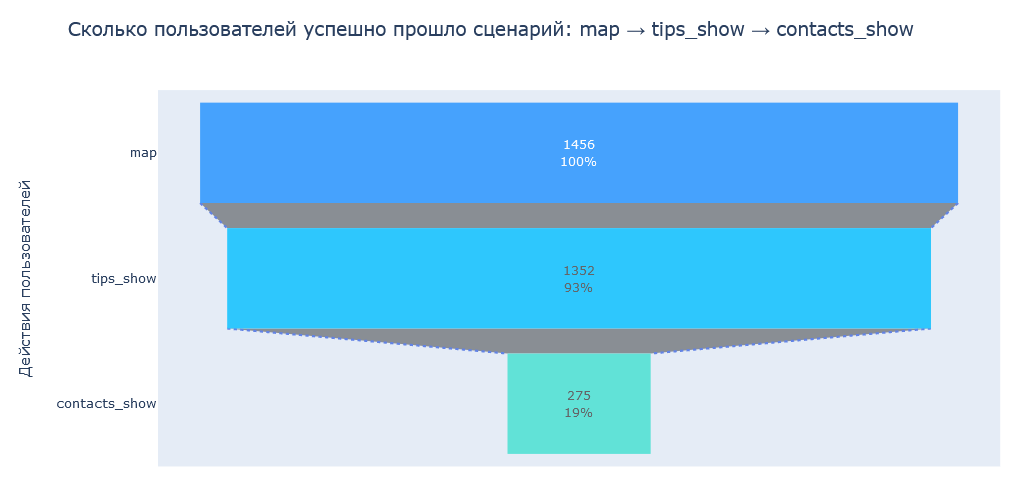

6. Стоит обратить внимание на источники и подумать, как увеличить поток пользователей с google - именно в этой категории  больше всего целевых пользователей (42 %). Эти данные имеют статистическую значимость.
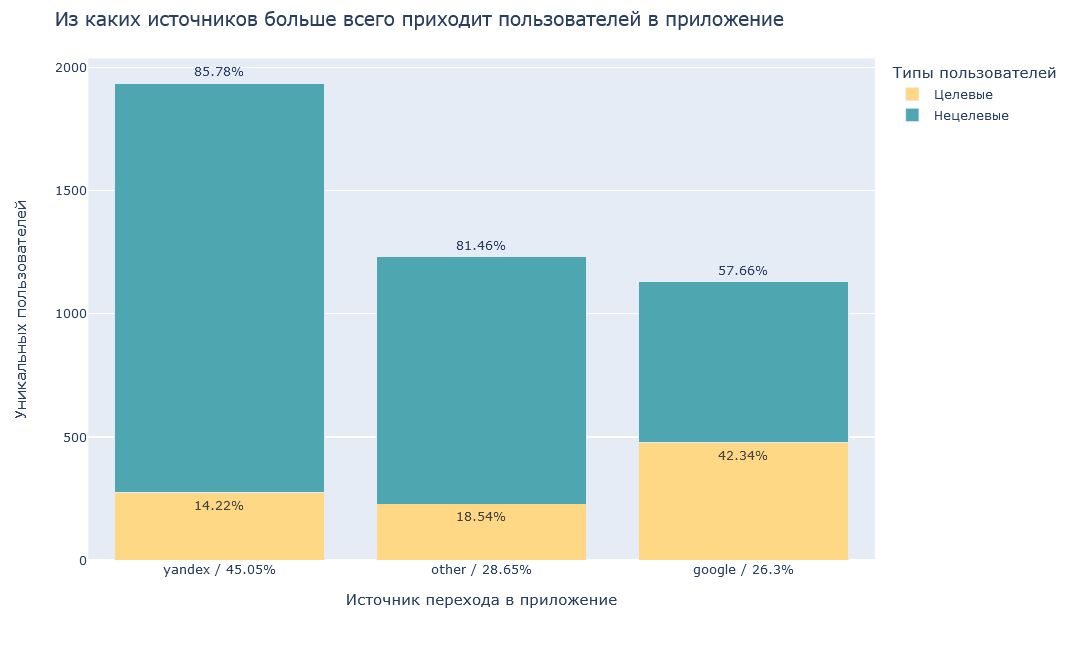

7. Оценка производительност приложения (временные замеры между ключевыми событиями в сессиях пользователей):
- среднее время перехода от карты объявлений к детальной карточке товара составляет 3 минуты 47 сек.
- среднее время перехода между поиском и карточкой товара составляет уже 12 минут 28 сек. Это очень большая разница между релевантными событиями, возможно в сервисе есть какие-то проблемы.
- если пользователь открыл карточку товара, то рекомендации он увидит в среднем через 1:04 минуты. Наверное, это хороший показатель, чтобы не ущемлять обычные объявления рекомендованными.
- если пользователь посмотрел фотографии товара и они ему понравились, то в избранное он добавит товар только через 6:39. Такое событие должно наступать раньше, конверсия из избранных выше обычных объявлений (это статистически значимый результат) - стоит детально проанализировать, в чем может быть причина.


8. Рекомендации: <br>
настоятельно рекомендуем собирать информацию об id объявлений и категории товаров, при текущем исследовании мы не располагали такой информацией, на основе этих данных можно было бы выделить самые "продаваемые" категории товаров и получить более точную информацию о поведении пользователей во время сессий.